# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [598]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [599]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [600]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

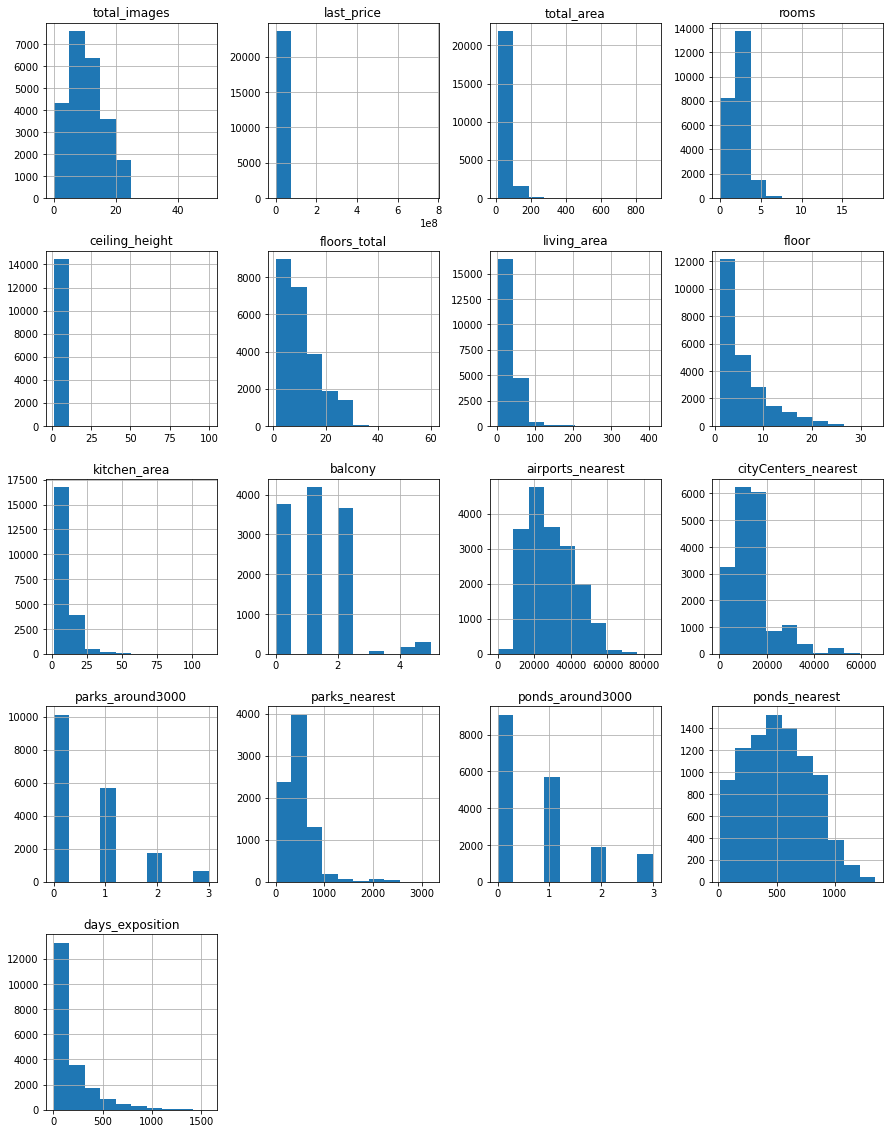

In [601]:
data.hist(figsize=(15, 20));

Аномалии (предварительно): 

- малое число квартир с общей площадью (tatal_area) более 100 м2
- малое число квартир с количеством комнат (rooms) 5 и более
- малое число квартир в домах с этажностью (floor) более 30 (вероятно, незначительное число квартир с этажностью более 20 только в СПб)
- малое число квартир с жилой площадью (living_area) более 100 м2 (логично, учитывая tatal_area)
- малое количество квартир площадью кухни (kitchen_area)  25 м2 и более (вероятно выбросы или ошибки)
- малое количество квартир с числом балконов (balcony) более 2х (вероятно выбросы или ошибки)
- малое количество квартир расположенных слишком близко (менее 10 км) и слишком далеко (более 60 км) от аэропорта
- малое количество квартир расположенных слишком далеко от центра (более 40 км) от центра
- малое количество квартир со слишком большим расстоянием до парка (1 км и более) то же с водоемом (более 1 км), логично обычно водоем идет в комплакте с парком

Вероятно когда уйдут эти аномалии меньше аномалий станет и во времени продажи (мало квартир продающихся дольше 1,5 года, т.е. более 500 дней)

In [602]:
# дату и время в правильны формат
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

### Предобработка данных

In [603]:
print(data.isna().sum()) # сумма пропусков по столбцам 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Соображения о заполнении пропусков:

- [X] высота потолков (ceiling_height) заполнить медианой по населенному пункту (и по близости к центру, если есть влияние; возможно, у квартир близко к центру в СПб потолки выше, чем у тех, которые дальше)
- [X] количество этажей (floors_total) может быть пропущено в одноэтажные домах (data['floor'] == 1), т.е. в таких случаях количество этажей 1. 
- [X] в студиях и квартирах с открытой планировкой ((data[studio] == True) & (data[open_plan] == True)) жилая площадь(living_area) по всей очевидности равна общей площади (data[living_area] = data [total_area]), т.к. балконы в общую площадь не входят.
- [X] в студиях и квартирах с открытой планировкой ((data[studio] == True) & (data[open_plan] == True)) площадь кухни = 0 (data['kitchen_area'] = data['kitchen_area'].fillna(0))
- в is_apartment пропуски могут оказаться False - проверить, (т.е. если не апартаменты при заполнении могли ничего не ставить)
- [X] пропуски в количестве балконов скорее всего означают, что их нет data['balcony'] = data['balcony'].fillna(0)
- [x] количество пропусков в столбцах 'parks_around3000' и 'ponds_around3000' - совпадают между собой, из описания этих переменных это означает (что в радиусе 3 км парков и водоемов нет), а также с 'cityCenters_nearest' и 'airports_nearest' - это означает в радиусе 3 км нет центра и аэропорта, что эти все строки нужно проверить. Из анализа гистограм частотности известно, что количество квартир со слишком большим расстоянием до парка (1 км и более) то же с водоемом - мало. Возможно эти пропуский увеличат эту категорию. Однако тогда нужна перекатегоризация - объединение всех квартир расстояние которых до парка и водоема более 1 км. (С расстоянием до центра и до аэропорта такой легкой перекатгоризации не выйдет, т.к. там другие масштабы далекого расстояния). 
- предыдущий пункт сократит на 5518 значений соответственно, количество пропусков в parks_nearest и ponds_nearest 
- locality_name. Можно по средним стоимостям при прочих равных показателях для квартиры попытаться определить СПб это или нет.
- пропуски в days_exposition могут означать, что либо квартиру продали в то же день, в которой объявление было размещено (это вероятно, если при прочих равных она продавалась по сравнительно не высокой цене), либо что количество дней, сколько провисели объясвление не известно, т.к. квартира еще не продана (поскольку first_day_exposition известно для всех объявлений). 

Средние можно начинать считать только после того, как преобразованы типы данных, устранены неявные дубликаты, а также аномалии.

In [604]:
# проверим пропуски в floors_total 

data_1floor = data.query('floor > 1')
print(data_1floor.isna().sum()) 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8099
floors_total               83
living_area              1650
floor                       0
is_apartment            18331
studio                      0
open_plan                   0
kitchen_area             1969
balcony                  9593
locality_name              44
airports_nearest         4622
cityCenters_nearest      4601
parks_around3000         4600
parks_nearest           13681
ponds_around3000         4600
ponds_nearest           12660
days_exposition          2734
dtype: int64


Если исключить из датафрейма квартиры на 1 этаже, т.е. оставить только те дома, в которых этажей гарантированно больше одного, количество пропусков в 'floors_total' не изменилось значительно. Значит NaN в 'floors_total' нельзя заменить на 1.

In [605]:
# удалим строки с пропусками в 'floors_total'
data = data.dropna(subset=['floors_total'])
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1870
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64


In [606]:
#в студиях и квартирах с открытой планировкой площадь кухни = 0

data.loc[(data['studio'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0
data.loc[(data['open_plan'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1870
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2018
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64


In [607]:
#в студиях и квартирах с открытой планировкой living_area = total_area

data.loc[(data['studio'] == True) & (data['living_area'].isna()), 'living_area'] = data.loc[data['studio'] == True, 'total_area']
data.loc[(data['open_plan'] == True) & (data['living_area'].isna()), 'living_area'] = data.loc[data['open_plan'] == True, 'total_area']
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1858
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2018
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64


In [608]:
# Пропуски в количестве балконов скорее всего означают, что их нет
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1858
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2018
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64


In [609]:
# Пропуски в количестве парков и прудов в радиусе 3 км, скорее всего означают, что их нет

data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1858
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2018
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition          3172
dtype: int64


Устраним неявные дубликаты в названиях населенных пунктов

In [610]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [611]:
data['locality_name'] = data['locality_name'].replace('посёлок Тельмана', 'поселок Тельмана')
data['locality_name'] = data['locality_name'].replace('посёлок Петровское', 'поселок Петровское')
data['locality_name'] = data['locality_name'].replace('посёлок Петровское', 'поселок Петровское')

duplicates = ['поселок городского типа Рябово', 'посёлок городского типа Рябово']
name = 'поселок Рябово'
data['locality_name'] = data['locality_name'].replace(duplicates, name)

In [612]:
# замена всех ё на е в названиях населенных пунтктов

data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [613]:
# замена "поселков городского типа" и  "городских поселков" на "поселки"

sub_duplicates = ['поселок городского типа', 'городской поселок']
sub_name = 'поселок'
# data['locality_name'] = data['locality_name'].str.replace(sub_duplicates, sub_name)# не срабатывает

data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('село', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество')

In [614]:
# при замене село на поселок получились попоселокк - исправим
data['locality_name'] = data['locality_name'].str.replace('попоселокк', 'поселок')

In [615]:
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок станции')

In [616]:
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок при станции')

In [617]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'поселок Красный Бор' 'Гатчина'
 'деревня Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'поселок Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'поселок Бугры' 'поселок Рощино' 'Кириши'
 'Луга' 'Волосо

In [618]:
data['locality_name'] = data['locality_name'].fillna(value='')

Создадим обобщающую переменную с типом населенного пункта из названия

In [619]:
def locality_type(locality_name):
    try:
        if 'поселок' in locality_name:
            return 'поселок'
        elif 'деревня' in locality_name or 'садовое товарищество' in locality_name:
            return 'деревня'
        else:
            return 'город'
    except:
        pass

data['locality_type'] = data['locality_name'].apply(locality_type)# примените функцию методом apply()

In [620]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21755 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21595 non-null  float64       
 13  balcony         

Заменим пропуски в высоте потолков

In [621]:
print(data.sort_values(by='ceiling_height', ascending = False).head(20)) # посмотрим на самые высокие потолки

       total_images  last_price  total_area first_day_exposition  rooms  \
22869             0  15000000.0        25.0           2018-07-25      1   
3148             14   2900000.0        75.0           2018-11-12      3   
22336            19   9999000.0        92.4           2019-04-05      2   
21377            19   4900000.0        42.0           2017-04-18      1   
20478            11   8000000.0        45.0           2017-07-18      1   
4876              7   3000000.0        25.0           2017-09-27      0   
17857             1   3900000.0        56.0           2017-12-22      3   
10773             8   3800000.0        58.0           2017-10-13      2   
5807             17   8150000.0        80.0           2019-01-09      2   
5246              0   2500000.0        54.0           2017-10-13      2   
21824            20   2450000.0        44.0           2019-02-12      2   
22938            14   4000000.0        98.0           2018-03-15      4   
5669              4   440

In [622]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21755 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21595 non-null  float64       
 13  balcony         

In [623]:
# заполним пропуски в высоте потолков медианой по типу населенного пункта, чтобы исключить влияние котеджей с высокими потолками (до 5 м.) 
for d in data['locality_type'].unique():
    data.loc[(data['locality_type'] == d) & (data['ceiling_height'].isna()), 'ceiling_height'] = data.loc[(data['locality_type'] == d), 'ceiling_height'].median()


In [624]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21755 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21595 non-null  float64       
 13  balcony         

In [625]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1858
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2018
balcony                     0
locality_name               0
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition          3172
locality_type               0
dtype: int64


In [626]:
# функция, которая разделит на 10 высоту потолков там, где она 25 вместо 2.5 м и т.п.

def norm_height (h):
    if h >= 10:
        h = h / 10
    else:
        h = h
        return h

data['ceiling_height'] = data['ceiling_height'].apply(norm_height)

In [627]:
data['ceiling_height'].describe()

count    23588.000000
mean         2.694996
std          0.233695
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          8.300000
Name: ceiling_height, dtype: float64

In [628]:
print(data.sort_values(by='ceiling_height', ascending = False).head(20))

       total_images   last_price  total_area first_day_exposition  rooms  \
5863             20    5650000.0        45.0           2018-08-15      1   
3474              3    1400000.0        30.0           2018-03-16      1   
15743            14    5600000.0        67.0           2016-11-11      3   
17442             0    5350000.0        54.0           2015-06-16      2   
20264            17  119000000.0       187.6           2017-07-10      4   
21227             0    8200000.0        71.0           2017-07-21      0   
1388             20   59800000.0       399.0           2015-01-21      5   
7578             17   38000000.0       143.0           2017-11-02      3   
12628            14    3900000.0        50.0           2018-03-29      1   
1026             20  155000000.0       310.0           2018-10-12      5   
464              15   66571000.0       280.3           2015-06-11      6   
1053             13     550000.0        29.0           2018-02-01      1   
21923       

Теперь 20-и метровых потолков нет, но остались 8,5 и 4-х метровые потолки в основном в СПб, но не так близко к центру как предполагалось. Можно проверить есть ли зависимость высоты сверхвысоких потолков (более 3.5 м) в СПб от близости к центру в СПб.

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='ceiling_height'>

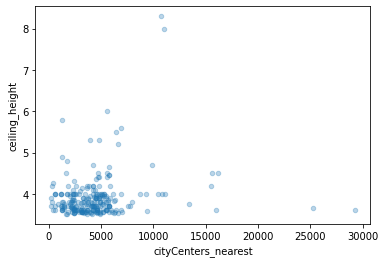

In [629]:
data_test = data.query('locality_name == "Санкт-Петербург" and ceiling_height > 3.5')
data_test.plot(kind='scatter', x='cityCenters_nearest', y='ceiling_height', alpha=0.3)

Линейной зависимости высоты сверхвысоких потолков (более 3.5 м) в СПб от близости к центру - нет. Потолки по 8 м - аномалии. Можно удалять.

In [630]:
# оставим в датафрейме потолки от 5 м - остальное аномалии (красиво жить не запретишь)
data = data[(data['ceiling_height'] <= 5)] 

In [631]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23577 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23577 non-null  int64         
 1   last_price            23577 non-null  float64       
 2   total_area            23577 non-null  float64       
 3   first_day_exposition  23577 non-null  datetime64[ns]
 4   rooms                 23577 non-null  int64         
 5   ceiling_height        23577 non-null  float64       
 6   floors_total          23577 non-null  float64       
 7   living_area           21721 non-null  float64       
 8   floor                 23577 non-null  int64         
 9   is_apartment          2762 non-null   object        
 10  studio                23577 non-null  bool          
 11  open_plan             23577 non-null  bool          
 12  kitchen_area          21566 non-null  float64       
 13  balcony         

In [632]:
data['ceiling_height'].describe() # 1-метровых (или 10 метровых до деления) потолков также не бывает

count    23577.000000
mean         2.693242
std          0.217523
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

In [633]:
print(data.sort_values(by='ceiling_height', ascending =True).head(20))

       total_images  last_price  total_area first_day_exposition  rooms  \
22590            16   6000000.0       55.00           2018-10-31      2   
5712              5   1500000.0       42.80           2017-08-14      2   
16934             5   4100000.0       40.00           2017-10-17      1   
22960            17   2300000.0       53.60           2018-10-18      2   
4212              1   2120000.0       35.43           2017-12-18      1   
11352             4   3300000.0       36.00           2017-06-18      1   
19329             5   1700000.0       40.00           2018-07-15      2   
5850              9   1650000.0       35.50           2018-05-29      1   
19098             7   2700000.0       56.00           2018-02-04      3   
2572              4   2400000.0       62.00           2018-12-27      3   
20520             9   3600000.0       38.00           2018-07-05      1   
552              11   2999000.0       33.50           2017-03-30      1   
16884             0   150

In [634]:
data_test2 = data.query('ceiling_height <= 2.5')
print('количество объектов недвижимости с потолками ниже 2.5 м включительно:', data_test2.shape[0])

количество объектов недвижимости с потолками ниже 2.5 м включительно: 3588


Квартир с низкими потолками в датафрейме довольно много. Посмотрим как они распределены в зависимости от типа населенного пункта. Возможно в деревнях и селах при строительстве частных домов экономили на материалах и делали потолки ниже нормы.

<AxesSubplot:xlabel='locality_type'>

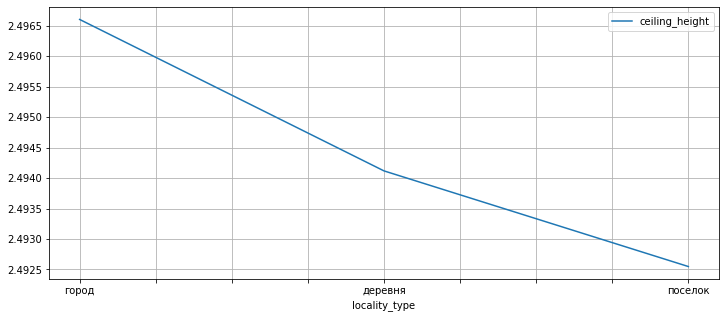

In [635]:
(
    data_test2
    .pivot_table(index='locality_type', values='ceiling_height')
    .plot(grid=True, figsize=(12, 5))   
) 

<AxesSubplot:xlabel='locality_type'>

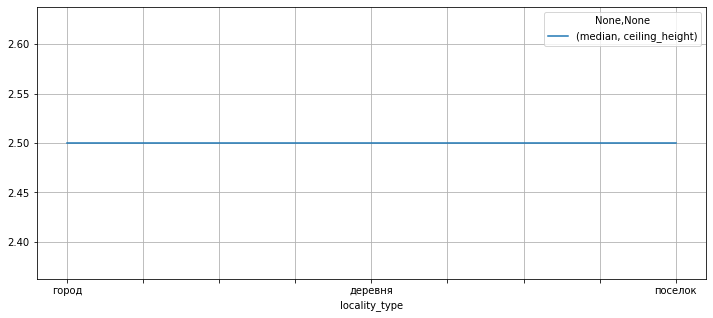

In [636]:
(
    data_test2
    .pivot_table(index='locality_type', values='ceiling_height', aggfunc=['median'])
    .plot(grid=True, figsize=(12, 5))   
) 

<AxesSubplot:xlabel='locality_type'>

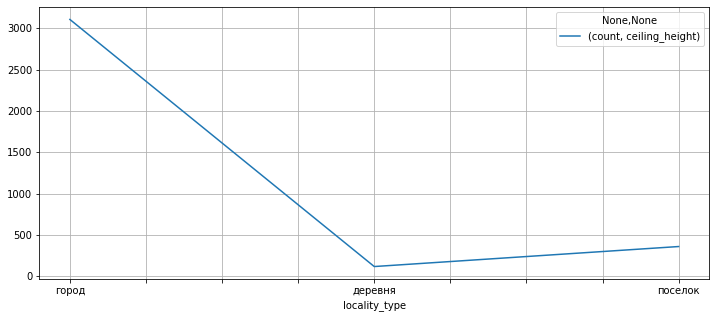

In [637]:
(
    data_test2
    .pivot_table(index='locality_type', values='ceiling_height', aggfunc=['count'])
    .plot(grid=True, figsize=(12, 5))   
) 

К счастью среднее и медиана квартир с очень низкими потолками во всех типах населенных пунктов - 2.5. Большая часть низких (невысоких) потолков в городах. Проверим сколько квартир с потолками ниже 2.5, исключая 2.5.  

In [638]:
data_test3 = data.query('ceiling_height < 2.5')
print('количество объектов недвижимости с потолками ниже 2.5 м исключительно:', data_test3.shape[0])

количество объектов недвижимости с потолками ниже 2.5 м исключительно: 73


In [639]:
# Всего 73 квартиры с потолками ниже 2.5 м исключительно  - их и сключим как аномалии.
data = data[(data['ceiling_height'] >= 2.5)]

In [640]:
data['ceiling_height'].describe()

count    23504.000000
mean         2.694436
std          0.216291
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

In [641]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1850
floor                       0
is_apartment            20754
studio                      0
open_plan                   0
kitchen_area             2004
balcony                     0
locality_name               0
airports_nearest         5491
cityCenters_nearest      5468
parks_around3000            0
parks_nearest           15500
ponds_around3000            0
ponds_nearest           14480
days_exposition          3154
locality_type               0
dtype: int64


Слишком большие значения в total_area

In [642]:
data['total_area'].describe()

count    23504.000000
mean        60.344468
std         35.560561
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

In [643]:
print(data.sort_values(by='total_area', ascending = False).head(20))

       total_images   last_price  total_area first_day_exposition  rooms  \
19540             8  420000000.0      900.00           2017-12-06     12   
12859            20  140000000.0      631.20           2019-04-09      7   
3117             19  140000000.0      631.00           2019-03-30      7   
15651            20  300000000.0      618.00           2017-12-18      7   
5358             20   65000000.0      590.00           2019-02-14     15   
4237              1   50000000.0      517.00           2017-10-14      7   
8018             20   84000000.0      507.00           2015-12-17      5   
15016             8  150000000.0      500.00           2016-01-13      4   
5893              3  230000000.0      500.00           2017-05-31      6   
12401            20   91500000.0      495.00           2017-06-19      7   
9826              1   43185328.0      494.10           2017-05-12      1   
22494             7   91075000.0      491.00           2017-05-27      5   
6621        

In [644]:
sample = data.query('total_area > 200')
print('количество объектов недвижимости с общей площадью более 200 м:', sample.shape[0])

количество объектов недвижимости с общей площадью более 200 м: 223


Это как правило квартиры в СПб с вменяемой высотой потолков, но в них как правило слишком большое количество комнат.

In [645]:
sample1 = data.query('rooms > 5')
print('количество объектов недвижимости с количеством комнат больше 5:', sample1.shape[0])

количество объектов недвижимости с количеством комнат больше 5: 193


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

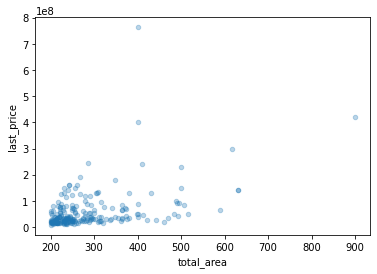

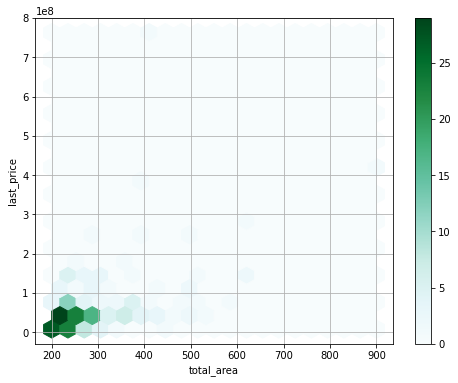

In [646]:
# зависимость цены очень больших квартир от их площади (не очень заметно)

sample2 = data.query('total_area > 200')
sample2.plot(kind='scatter', x='total_area', y='last_price', alpha=0.3)
sample2.plot(kind='hexbin', x='total_area', y='last_price', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

<AxesSubplot:xlabel='total_area', ylabel='rooms'>

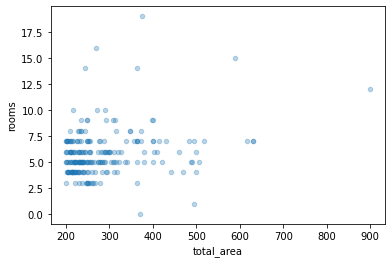

In [647]:
# зависимость количества комнат от площади
sample2 = data.query('total_area > 200')
sample2.plot(kind='scatter', x='total_area', y='rooms', alpha=0.3)

В квартирах с очень большой площадью (более 200 м.) не наблюдается линейной зависимости цены этой квартиры и количества комнат в ней от площади. Цена и так слишком дорогая. Т.е. это какие-то аномалии.

In [648]:
# оставим в датафрейме только те квартиры, в которых не более 5 комнат 
data = data[(data['rooms'] <= 5)] 

In [649]:
sample = data.query('total_area > 200')
print('осталось квартир с общей площадью более 200 м:', sample.shape[0])

осталось квартир с общей площадью более 200 м: 115


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

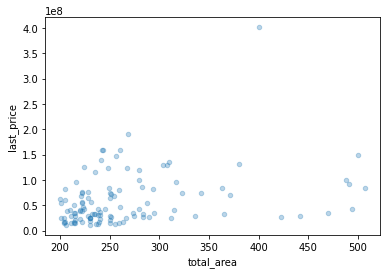

In [650]:
sample2 = data.query('total_area > 200')
sample2.plot(kind='scatter', x='total_area', y='last_price', alpha=0.3)

Все, что больше 300 (на 5 комнат) выглядит аномально, больше 400 - наверняка аномально, т.к. виден разрыв в распределении: м-ду 370 и 420 м. одна квартира 400 с астраномической ценой.

In [651]:
data = data[(data['total_area'] < 300)] # оставим квартиры с общей площадью менее 300 м.

In [652]:
data['total_area'].describe()

count    23289.000000
mean        58.563074
std         28.237410
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        295.000000
Name: total_area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

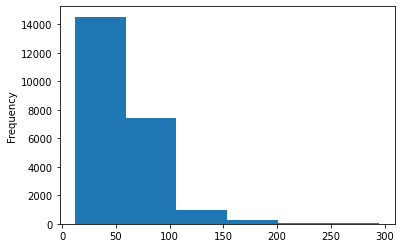

In [653]:
data['total_area'].plot(kind='hist', bins=6)

0 комнат

In [654]:
data['rooms'].describe() 

count    23289.000000
mean         2.028683
std          0.970822
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

In [655]:
sample3 = data.query('rooms == 0')
print('количество объектов недвижимости с количеством комнат 0:', sample3.shape[0])

количество объектов недвижимости с количеством комнат 0: 191


Судя по средним значениям total_area, квартиры с 0 комнат это однокомнатные квартиры или студии. 0 можно заменить на 1. Проверим

In [656]:
sample3['total_area'].describe()

count    191.000000
mean      27.337225
std        7.856824
min       15.500000
25%       24.025000
50%       26.050000
75%       28.250000
max       98.400000
Name: total_area, dtype: float64

In [657]:
sample3.sort_values(by='total_area', ascending = False).head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type
20082,10,16300000.0,98.40,2017-11-08,0,3.10,5.0,60.50,2,NaN,...,0,Санкт-Петербург,26972.0,5819.0,0,NaN,1,674.0,537.0,город
3458,6,7400000.0,73.60,2017-05-18,0,2.65,3.0,50.00,1,NaN,...,0,Санкт-Петербург,26581.0,6085.0,0,NaN,1,348.0,60.0,город
13613,16,8100000.0,58.40,2019-04-26,0,3.30,7.0,33.00,6,NaN,...,0,Санкт-Петербург,14509.0,8288.0,0,NaN,0,NaN,NaN,город
10008,20,5050000.0,44.20,2017-09-14,0,2.70,9.0,32.20,1,NaN,...,0,Санкт-Петербург,24329.0,5955.0,0,NaN,2,520.0,69.0,город
15319,4,5970000.0,43.30,2017-07-20,0,2.80,9.0,28.20,2,NaN,...,2,Санкт-Петербург,23617.0,5223.0,0,NaN,1,874.0,30.0,город
7237,8,2999000.0,42.63,2017-11-27,0,2.65,16.0,25.70,2,NaN,...,2,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45.0,деревня
16130,14,5000000.0,42.10,2018-04-13,0,2.65,20.0,30.00,10,NaN,...,0,Санкт-Петербург,50605.0,15933.0,0,NaN,0,NaN,170.0,город
9052,12,3890000.0,38.30,2017-10-06,0,2.70,14.0,24.42,7,NaN,...,2,Санкт-Петербург,15493.0,14289.0,0,NaN,0,NaN,289.0,город
4683,2,3650000.0,35.00,2018-02-01,0,2.65,25.0,23.40,25,NaN,...,0,Санкт-Петербург,43431.0,12188.0,0,NaN,0,NaN,100.0,город
839,14,1900000.0,35.00,2017-04-14,0,2.70,5.0,15.00,3,False,...,1,поселок Новый Свет,NaN,NaN,0,NaN,0,NaN,7.0,поселок


In [658]:
# 0 комнат - студии ли это?

sample4 = sample3[['total_area','living_area','studio','open_plan','locality_type','locality_name',]]
sample4.sort_values(by='total_area', ascending = False).head(20)

,total_area,living_area,studio,open_plan,locality_type,locality_name
20082,98.40,60.50,True,False,город,Санкт-Петербург
3458,73.60,50.00,True,False,город,Санкт-Петербург
13613,58.40,33.00,True,False,город,Санкт-Петербург
10008,44.20,32.20,True,False,город,Санкт-Петербург
15319,43.30,28.20,True,False,город,Санкт-Петербург
7237,42.63,25.70,False,True,деревня,деревня Кудрово
16130,42.10,30.00,True,False,город,Санкт-Петербург
9052,38.30,24.42,True,False,город,Санкт-Петербург
4683,35.00,23.40,False,True,город,Санкт-Петербург
839,35.00,15.00,False,True,поселок,поселок Новый Свет


Да, квартиры с 0 комнат это как правило студии в СПб, либо открытая планировка там и/или в др. населенных пунктах. Соответственно среднюю площадь однокомнатной квартиры по всему датафрейму считать и сравнивать с выборкой квартир с 0 комнат не нужно. Земеняем 0 комнат на 1.

In [659]:
data.loc[(data['rooms'] == 0), 'rooms'] = 1

In [660]:
data['rooms'].describe() 

count    23289.000000
mean         2.036884
std          0.957785
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

Поработаем с площадью кухни

In [661]:
data['kitchen_area'].describe()

count    21310.000000
mean        10.347743
std          5.683298
min          0.000000
25%          7.000000
50%          9.000000
75%         11.900000
max        107.000000
Name: kitchen_area, dtype: float64

In [662]:
sample5 = data[['total_area','living_area','kitchen_area','rooms','studio','open_plan', 'is_apartment', 'locality_type','locality_name']]

In [663]:
sample5.sort_values(by='kitchen_area', ascending = False).head(20)

,total_area,living_area,kitchen_area,rooms,studio,open_plan,is_apartment,locality_type,locality_name
20215,249.7,72.0,107.0,3,False,False,NaN,город,Санкт-Петербург
2489,255.0,153.9,100.7,3,False,False,NaN,город,Санкт-Петербург
16239,181.1,58.2,93.2,3,False,False,False,город,Санкт-Петербург
16797,146.0,40.0,93.0,2,False,False,NaN,город,Санкт-Петербург
10867,177.9,87.2,87.2,3,False,False,True,город,Санкт-Петербург
492,216.0,86.0,77.0,4,False,False,NaN,город,Санкт-Петербург
4394,174.0,95.0,77.0,3,False,False,NaN,город,Санкт-Петербург
14644,150.0,58.0,75.0,4,False,False,NaN,город,Санкт-Петербург
16647,145.0,36.0,72.0,3,False,False,NaN,город,Санкт-Петербург
6193,230.0,90.0,70.0,4,False,False,False,город,Санкт-Петербург


<AxesSubplot:xlabel='total_area', ylabel='kitchen_area'>

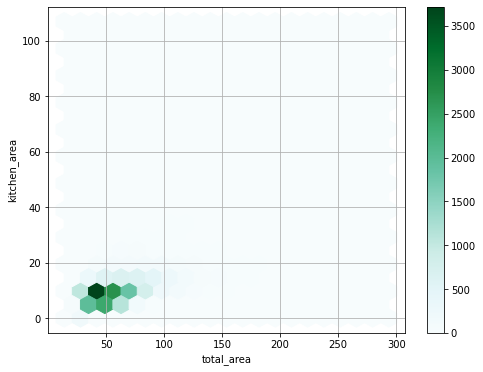

In [664]:
sample5.plot(kind='hexbin', x='total_area', y='kitchen_area', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

Очевидной и сильной линейной зависимости между общей площадью квартиры и площадью кухни не выявлено. Убедимся, что данные о площади кухни пропщены не в студиях и квартирах со свободной планировкой (там она должна быть 0). 

In [665]:
sample6 = sample5.loc[sample5['kitchen_area'].isna()]
print(sample6.head(20))

     total_area  living_area  kitchen_area  rooms  studio  open_plan  \
3         159.0          NaN           NaN      3   False      False   
30         32.8          NaN           NaN      1   False      False   
37         45.8          NaN           NaN      2   False      False   
44         40.0          NaN           NaN      1   False      False   
59         46.5          NaN           NaN      1   False      False   
60         35.0          NaN           NaN      1   False      False   
81         68.0          NaN           NaN      1   False      False   
82         80.5          NaN           NaN      3   False      False   
133        31.0          NaN           NaN      1   False      False   
164        40.3          NaN           NaN      2   False      False   
166        60.0          NaN           NaN      2   False      False   
178       153.0         89.4           NaN      4   False      False   
188        38.5         18.5           NaN      1   False      F

Пропуски в kitchen_area можно было бы заполнить медианным значением или, если пренебречь коридорами и санузлами заполнить по формуле total_area - living_area (там где оба этих значения присутствуют). Последнее бы увеличило стандартное отклонение kitchen_area. 

Апартаменты

In [666]:
# пропуски в переменной is_apartment скорее всего означают, 
# что рассматриваемая квартира - не апартаменты (False)

data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'] = data['is_apartment'].astype('bool')

In [667]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1831
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             1979
balcony                     0
locality_name               0
airports_nearest         5484
cityCenters_nearest      5463
parks_around3000            0
parks_nearest           15432
ponds_around3000            0
ponds_nearest           14406
days_exposition          3093
locality_type               0
dtype: int64


In [668]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23289 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23289 non-null  int64         
 1   last_price            23289 non-null  float64       
 2   total_area            23289 non-null  float64       
 3   first_day_exposition  23289 non-null  datetime64[ns]
 4   rooms                 23289 non-null  int64         
 5   ceiling_height        23289 non-null  float64       
 6   floors_total          23289 non-null  float64       
 7   living_area           21458 non-null  float64       
 8   floor                 23289 non-null  int64         
 9   is_apartment          23289 non-null  bool          
 10  studio                23289 non-null  bool          
 11  open_plan             23289 non-null  bool          
 12  kitchen_area          21310 non-null  float64       
 13  balcony         

In [669]:
# количество этажей это целой число 
data['floors_total'] = data['floors_total'].astype('int')
data['floor'] = data['floor'].astype('int')

Пропуски в расстояниях до центра города и аэропорта

In [670]:
sample7 = data[(data['airports_nearest'].isna()) & (data['cityCenters_nearest'].isna())]
sample7 = sample7[['rooms', 'airports_nearest', 'cityCenters_nearest', 'locality_type', 'locality_name']]
print(sample7.head(30))

     rooms  airports_nearest  cityCenters_nearest locality_type  \
5        1               NaN                  NaN       поселок   
8        1               NaN                  NaN       поселок   
12       2               NaN                  NaN         город   
22       2               NaN                  NaN       деревня   
30       1               NaN                  NaN         город   
37       2               NaN                  NaN       поселок   
38       1               NaN                  NaN       поселок   
47       3               NaN                  NaN         город   
60       1               NaN                  NaN       поселок   
62       3               NaN                  NaN         город   
64       2               NaN                  NaN         город   
66       1               NaN                  NaN       поселок   
68       3               NaN                  NaN       деревня   
69       2               NaN                  NaN         горо

In [671]:
sample8 = sample7.query('locality_name == "Санкт-Петербург"')
print('СПб встречается среди объявлений в отсутствием расстояния до центра и до аэропорта', sample8.shape[0])

СПб встречается среди объявлений в отсутствием расстояния до центра и до аэропорта 57


Те квартиры для которых пропуски до центра города и до аэропорта в большинстве располагаются в селах и деревнях ленинградской области с расстоянием до аэропорта Пулково, судя по Яндекс-картам более 40 км. И 57 пропусков для объявлений СПб. Можно было бы нати уникальные названия населенных пунктов (исключая СПб) и заполнить пропуски для них циклом расстоянием до Пулкова из Яндекс-карт. На самом деле эти метрики важны только для квартир в СПб.  

In [672]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1831
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             1979
balcony                     0
locality_name               0
airports_nearest         5484
cityCenters_nearest      5463
parks_around3000            0
parks_nearest           15432
ponds_around3000            0
ponds_nearest           14406
days_exposition          3093
locality_type               0
dtype: int64


In [673]:
print(data.duplicated().sum()) # дубликатов нет

0


Балконы

In [674]:
sample8 = data.query('balcony > 3')
print('количество объектов недвижимости с количеством балконов больше 3-х:', sample8.shape[0])

количество объектов недвижимости с количеством балконов больше 3-х: 479


In [675]:
sample8 = sample8[['total_area','living_area','kitchen_area','rooms','balcony','studio','open_plan', 'is_apartment', 'locality_type','locality_name']]
sample8

,total_area,living_area,kitchen_area,rooms,balcony,studio,open_plan,is_apartment,locality_type,locality_name
41,74.00,59.0,12.0,3,5,False,False,False,город,Санкт-Петербург
42,161.80,80.9,17.6,4,5,False,False,False,город,Петергоф
116,97.20,NaN,18.3,3,5,False,False,False,город,Санкт-Петербург
121,180.00,86.0,24.0,3,4,False,False,False,город,Санкт-Петербург
250,51.70,29.2,7.7,2,4,False,False,False,город,Всеволожск
...,...,...,...,...,...,...,...,...,...,...
23363,52.00,28.0,11.0,1,5,False,False,False,поселок,поселок Мурино
23474,40.50,31.0,5.0,2,4,False,False,False,город,Санкт-Петербург
23497,55.40,29.4,9.6,2,4,False,False,False,город,Санкт-Петербург
23526,60.69,39.7,6.2,3,5,False,False,False,город,Санкт-Петербург


Количество балконов не может быть больше количества комнат. Оставим только те объявления, в которых количество балконов не превышает количество комнат. 

In [676]:
sample82 = data.query('balcony > rooms')
print('количество объектов недвижимости у которых балконов больше чем комнат:', sample82.shape[0])

количество объектов недвижимости у которых балконов больше чем комнат: 2035


In [677]:
data = data[data['balcony'] <= data['rooms']]

In [678]:
data['floors_total'].describe()

count    21254.000000
mean        10.330902
std          6.462003
min          1.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         60.000000
Name: floors_total, dtype: float64

In [679]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21254 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21254 non-null  int64         
 1   last_price            21254 non-null  float64       
 2   total_area            21254 non-null  float64       
 3   first_day_exposition  21254 non-null  datetime64[ns]
 4   rooms                 21254 non-null  int64         
 5   ceiling_height        21254 non-null  float64       
 6   floors_total          21254 non-null  int64         
 7   living_area           19503 non-null  float64       
 8   floor                 21254 non-null  int64         
 9   is_apartment          21254 non-null  bool          
 10  studio                21254 non-null  bool          
 11  open_plan             21254 non-null  bool          
 12  kitchen_area          19341 non-null  float64       
 13  balcony         

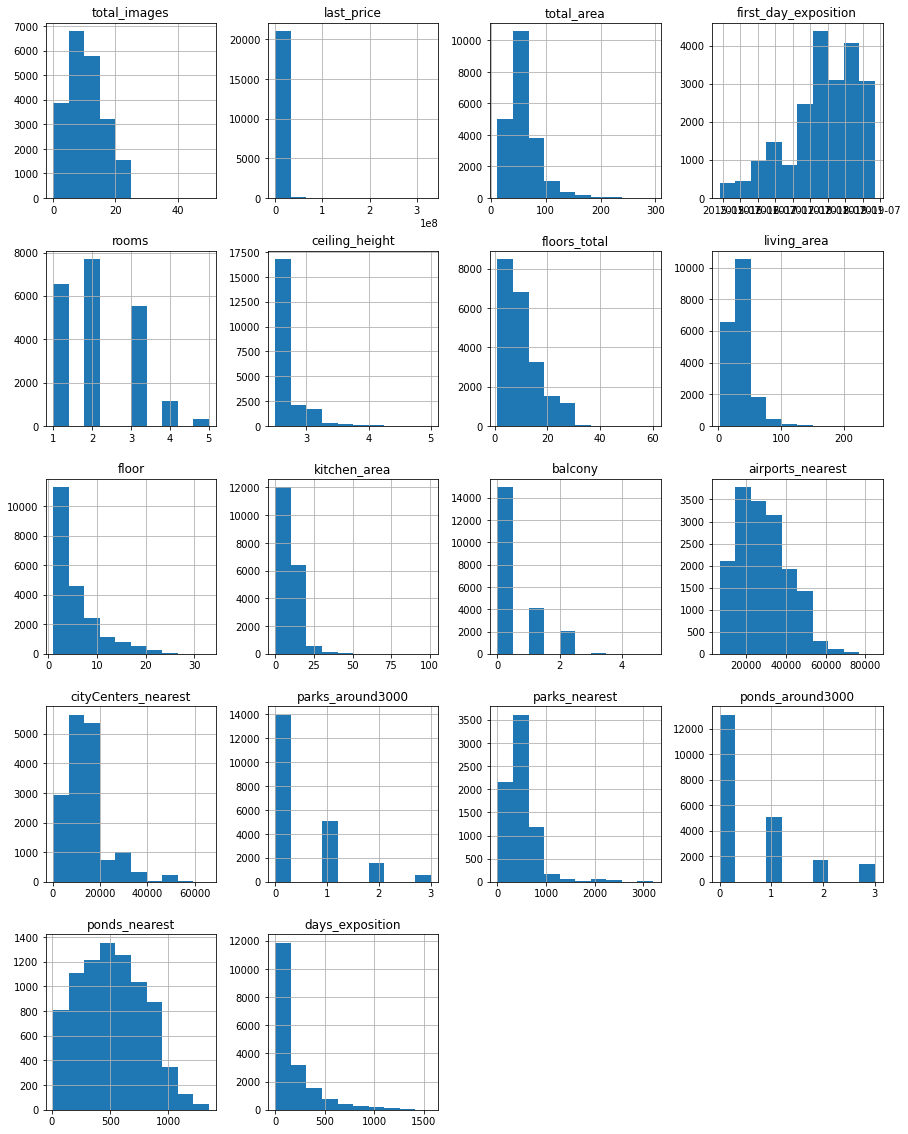

In [680]:
data.hist(figsize=(15, 20));

In [681]:
# цена цело чило, т.к. там тысячи, вероятно, рублей
data['last_price'] = data['last_price'].astype('int')

Вернулись к предобработке

In [682]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21254 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21254 non-null  int64         
 1   last_price            21254 non-null  int64         
 2   total_area            21254 non-null  float64       
 3   first_day_exposition  21254 non-null  datetime64[ns]
 4   rooms                 21254 non-null  int64         
 5   ceiling_height        21254 non-null  float64       
 6   floors_total          21254 non-null  int64         
 7   living_area           19503 non-null  float64       
 8   floor                 21254 non-null  int64         
 9   is_apartment          21254 non-null  bool          
 10  studio                21254 non-null  bool          
 11  open_plan             21254 non-null  bool          
 12  kitchen_area          19341 non-null  float64       
 13  balcony         

Слишком маленькая жилая площадь

In [683]:
data['living_area'].describe()

count    19503.000000
mean        34.347997
std         18.126723
min          2.000000
25%         19.500000
50%         30.800000
75%         42.800000
max        250.000000
Name: living_area, dtype: float64

In [684]:
display(data.sort_values(by='living_area', ascending=True).head(20))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type
13915,20,6350000,52.0,2018-02-06,2,3.00,6,2.0,2,False,...,0,Санкт-Петербург,32453.0,6521.0,0,NaN,1,1012.0,91.0,город
21758,0,2330000,23.0,2018-01-01,1,2.60,24,2.0,22,False,...,0,поселок Мурино,NaN,NaN,0,NaN,0,NaN,66.0,поселок
23574,14,64990000,139.0,2015-11-24,3,3.00,8,3.0,8,False,...,1,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,280.0,город
3242,7,4440000,41.0,2017-07-02,1,2.65,17,3.0,17,False,...,0,Санкт-Петербург,19272.0,13073.0,0,NaN,0,NaN,216.0,город
21943,15,6100000,77.6,2019-02-28,4,2.50,9,5.4,1,False,...,0,Санкт-Петербург,29338.0,11270.0,1,584.0,0,NaN,33.0,город
16431,13,3799000,31.0,2018-04-12,1,2.60,5,6.0,1,False,...,0,Санкт-Петербург,32177.0,4826.0,1,430.0,0,NaN,168.0,город
19251,19,4050000,33.0,2018-10-15,1,2.50,22,6.5,21,False,...,0,Санкт-Петербург,9258.0,10592.0,1,458.0,0,NaN,44.0,город
23208,12,4800000,37.0,2016-02-24,1,2.65,14,8.0,11,False,...,0,Санкт-Петербург,27838.0,12387.0,2,358.0,1,950.0,139.0,город
20994,7,8900000,50.6,2018-10-22,2,2.50,7,8.0,3,False,...,0,Санкт-Петербург,12771.0,8301.0,1,173.0,3,126.0,NaN,город
114,5,4000000,21.4,2019-02-07,1,2.90,8,8.3,7,False,...,0,Санкт-Петербург,27089.0,5791.0,2,488.0,1,286.0,NaN,город


In [685]:
sample13 = data.query('living_area < 10')
print('количество объектов недвижимости с жилой площадью менее 10 м:', sample13.shape[0])

количество объектов недвижимости с жилой площадью менее 10 м: 22


Учитывая что общую площадь решили начинать с 12 м. жилая менее 10 - аномалии.

In [686]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21254 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21254 non-null  int64         
 1   last_price            21254 non-null  int64         
 2   total_area            21254 non-null  float64       
 3   first_day_exposition  21254 non-null  datetime64[ns]
 4   rooms                 21254 non-null  int64         
 5   ceiling_height        21254 non-null  float64       
 6   floors_total          21254 non-null  int64         
 7   living_area           19503 non-null  float64       
 8   floor                 21254 non-null  int64         
 9   is_apartment          21254 non-null  bool          
 10  studio                21254 non-null  bool          
 11  open_plan             21254 non-null  bool          
 12  kitchen_area          19341 non-null  float64       
 13  balcony         

Заполним пропуски в living_area медианой для квартир с соответствующим количеством комнат 

In [687]:
for r in data['rooms'].unique():
    data.loc[(data['rooms'] == r) & (data['living_area'].isna()), 'living_area'] = data.loc[(data['rooms'] == r), 'living_area'].median()

In [688]:
# проверим не вышло ли так, что где то living_area получилась больше total_area
sample33 = data[data['living_area'] > data['total_area']]
print('количество квартир, в которых после заплолнения пропусков жилая площадь получилась больше общей:', sample33.shape[0])

количество квартир, в которых после заплолнения пропусков жилая площадь получилась больше общей: 27


In [689]:
# изучим те, в которых living_area получилась равна total_area
sample33 = data[data['living_area'] == data['total_area']]
sample33 = sample33[['total_area', 'living_area', 'kitchen_area', 'rooms', 'is_apartment', 'studio', 'open_plan']]
sample33

,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan
608,25.0,25.0,0.0,1,False,True,False
780,26.1,26.1,0.0,1,False,False,True
2409,27.0,27.0,0.0,1,False,True,False
3147,31.0,31.0,0.0,1,False,True,False
3874,21.4,21.4,0.0,1,False,True,False
8454,19.0,19.0,0.0,1,False,True,False
12691,24.2,24.2,0.0,1,False,False,True
17783,157.0,157.0,0.0,5,False,False,True
18028,31.0,31.0,0.0,1,False,True,False
23554,26.0,26.0,0.0,1,False,True,False


Варианты, когда после заполнения living_area получилась равна total_area допустимы, т.к. это студии или открытая планировка с площадью кухни 0.

In [690]:
data = data[data['living_area'] <= data['total_area']]

In [691]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21227 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21227 non-null  int64         
 1   last_price            21227 non-null  int64         
 2   total_area            21227 non-null  float64       
 3   first_day_exposition  21227 non-null  datetime64[ns]
 4   rooms                 21227 non-null  int64         
 5   ceiling_height        21227 non-null  float64       
 6   floors_total          21227 non-null  int64         
 7   living_area           21227 non-null  float64       
 8   floor                 21227 non-null  int64         
 9   is_apartment          21227 non-null  bool          
 10  studio                21227 non-null  bool          
 11  open_plan             21227 non-null  bool          
 12  kitchen_area          19340 non-null  float64       
 13  balcony         

In [692]:
# оставим в датафрейме квартиры с жилой площадью не менее 10 
data = data[data['living_area'] >= 10] 

In [693]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21205 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21205 non-null  int64         
 1   last_price            21205 non-null  int64         
 2   total_area            21205 non-null  float64       
 3   first_day_exposition  21205 non-null  datetime64[ns]
 4   rooms                 21205 non-null  int64         
 5   ceiling_height        21205 non-null  float64       
 6   floors_total          21205 non-null  int64         
 7   living_area           21205 non-null  float64       
 8   floor                 21205 non-null  int64         
 9   is_apartment          21205 non-null  bool          
 10  studio                21205 non-null  bool          
 11  open_plan             21205 non-null  bool          
 12  kitchen_area          19319 non-null  float64       
 13  balcony         

In [694]:
data['kitchen_area'].describe()

count    19319.000000
mean        10.326285
std          5.710668
min          0.000000
25%          7.000000
50%          9.000000
75%         11.825000
max        100.700000
Name: kitchen_area, dtype: float64

In [695]:
sample17 = data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'is_apartment', 'studio', 'open_plan']]
print(sample17.sort_values(by='kitchen_area', ascending=False).head(20))

       total_area  living_area  kitchen_area  rooms  is_apartment  studio  \
2489        255.0        153.9         100.7      3         False   False   
16239       181.1         58.2          93.2      3         False   False   
16797       146.0         40.0          93.0      2         False   False   
10867       177.9         87.2          87.2      3          True   False   
4394        174.0         95.0          77.0      3         False   False   
492         216.0         86.0          77.0      4         False   False   
14644       150.0         58.0          75.0      4         False   False   
16647       145.0         36.0          72.0      3         False   False   
6193        230.0         90.0          70.0      4         False   False   
18447       187.0        120.0          65.0      5         False   False   
22980       155.4         72.0          65.0      3         False   False   
17912       166.0         52.0          64.0      3         False   False   

In [696]:
sample17 = data[data['kitchen_area'] >= 70]
print('количество квартир с кухней 70 м и более:', sample17.shape[0])

количество квартир с кухней 70 м и более: 9


In [697]:
data.shape[0]

21205

In [698]:
# какую долю от нежилой площади занимает куня (если убрать выбросы в площади кухни)
sample_k = data[data['kitchen_area'] <= 30]
sample_k = data[data['kitchen_area'] >= 3]
sample_k = sample_k.dropna(subset=['kitchen_area'])

(sample_k['kitchen_area'] / (sample_k['total_area'] - sample_k['living_area'])).median()


0.408053215205999

In [699]:
# какую долю от нежилой площади занимает куня (если выбросы в площади кухни остаются)
(data['kitchen_area'] / (data['total_area'] - data['living_area'])).median()

0.4074074074074074

<AxesSubplot:xlabel='rooms', ylabel='kitchen_area'>

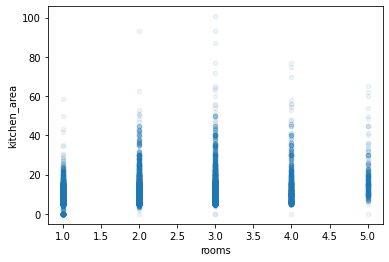

In [700]:
# есть ли влияние количества комнат на площадь кухни? (нелинейно)
data.plot(kind='scatter', x='rooms', y='kitchen_area', alpha=0.08)

In [701]:
data.pivot_table(index='rooms', values='kitchen_area', aggfunc=['median'])

,median
,kitchen_area
rooms,
1,9.0
2,8.7
3,9.4
4,11.0
5,15.0


Начиная с 2-х комнатных квартир средняя площадь кухни растет с количеством комнат, но порядок прироста площади не большой - всего несколько квадратных метром. 

In [702]:
# заполним пропуски в данных по формуле
data['kitchen_area'] = data['kitchen_area'].fillna((data['total_area'] - data['living_area'])*0.4)

In [703]:
# изучим те объявления, в которых после заполнения kitchen_area получилась больше или равна total_area - living_area
sample27 = data[data['kitchen_area'] > (data['total_area'] - data['living_area'])]
sample27.shape[0]

61

In [704]:
# уполовиним в них пощадь кухни
#data[data['kitchen_area'] > (data['total_area'] - data['living_area'], 'kitchen_area')] = 'kitchen_area' * 0.5


In [705]:
sample27 = sample27[['total_area', 'living_area', 'kitchen_area', 'rooms', 'is_apartment', 'studio', 'open_plan']]
sample27

,total_area,living_area,kitchen_area,rooms,is_apartment,studio,open_plan
184,30.20,26.1,6.20,1,False,False,False
545,23.80,20.0,5.00,1,False,False,False
601,53.70,48.3,7.00,2,False,False,False
1060,50.00,39.0,20.50,2,False,False,False
1155,38.00,33.0,12.00,1,False,False,False
...,...,...,...,...,...,...,...
21519,55.00,52.5,9.00,2,False,False,False
21915,91.40,62.0,32.40,2,False,False,False
21956,46.00,44.0,8.00,2,False,False,False
22399,54.80,39.5,15.30,3,False,False,False


In [706]:
data = data[(data['kitchen_area'] < 70)] # оставим в датасете только кухни менее 70 м

In [707]:
data.shape[0]

21193

In [708]:
data['last_price'].describe()

count    2.119300e+04
mean     6.246447e+06
std      7.338078e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.700000e+06
75%      6.800000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [709]:
sample16 = data.query('last_price > 0.300000e+08')
print('количество объектов недвижимости с астраномической ценой:', sample16.shape[0])

количество объектов недвижимости с астраномической ценой: 213


Учитывая, что в датафрейме осталось ок. 21000 строк. - 213 строк - это 1 %, соответственноо 0.300000e+08 - это 99-ый персентиль. Можно его удалить.

In [710]:
data = data[(data['last_price'] <= 0.300000e+08)]

In [711]:
data.shape[0]

20980

Общее количество этажей

In [712]:
sample66 = data.query('floors_total > 35')
print('количество объектов недвижимости с количеством этажей 35 и более :', sample66.shape[0])

количество объектов недвижимости с количеством этажей 35 и более : 4


Учитывая, что самая высокая из продающихся квартир на 33 этаже - это 4 дома с этажностью более 35 этажей - аномалии. Удаляем.

In [713]:
data = data[data['floors_total'] <= 35] # удаляем небоскребы

In [714]:
data.shape[0]

20976

### Посчитайте и добавьте в таблицу новые столбцы

In [716]:
# цена за 1 м2
data['1m'] = data['last_price'] / data['total_area']

In [717]:
# средняя цена за 1 м2 в зависимости от типа населенного пункта и количества комнат
data_pivot = data.pivot_table(index='locality_type', columns='rooms', values='1m', aggfunc=['mean','count'])
print(data_pivot)

                        mean                                             \
rooms                      1              2             3             4   
locality_type                                                             
город          105385.131178  100243.893050  96606.862680  99113.280436   
деревня         76476.473585   60020.952017  58545.085751  50708.505165   
поселок         77701.709164   63152.251115  58903.725964  54952.811993   

                            count                         
rooms                     5     1     2     3     4    5  
locality_type                                             
город          96858.729263  5244  6470  4820  1020  245  
деревня        65232.089837   349   308   153     9    3  
поселок        53049.175749   954   897   455    37   12  


4-х и 5-и комнатные квартиры в деревнях - редкость, логично. Влияние типа населенного пункт на стоимость м2 также видна. Вероятно цены СПб сильно влияют на средние для города.

<AxesSubplot:xlabel='locality_type'>

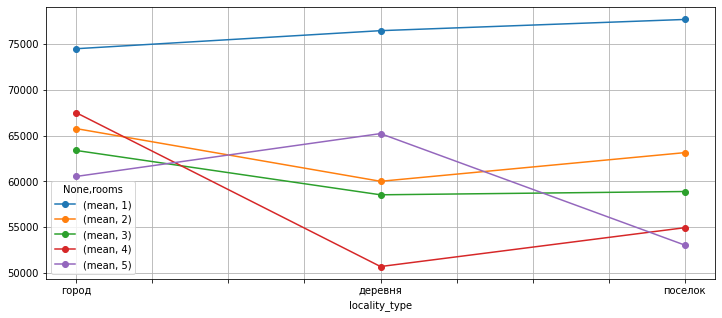

In [718]:
(
    data.query('locality_name != "Санкт-Петербург"')
    .pivot_table(index='locality_type', columns='rooms', values='1m', aggfunc=['mean'])
    .plot(grid=True, style='o-', figsize=(12, 5))   
) 

<AxesSubplot:xlabel='locality_type'>

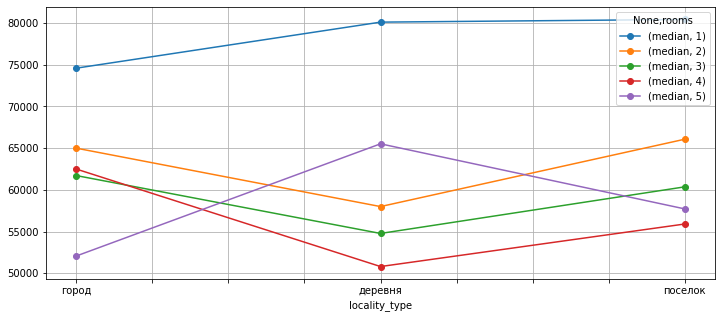

In [719]:
(
    data.query('locality_name != "Санкт-Петербург"')
    .pivot_table(index='locality_type', columns='rooms', values='1m', aggfunc=['median'])
    .plot(grid=True, style='o-', figsize=(12, 5))   
) 

<AxesSubplot:xlabel='locality_type'>

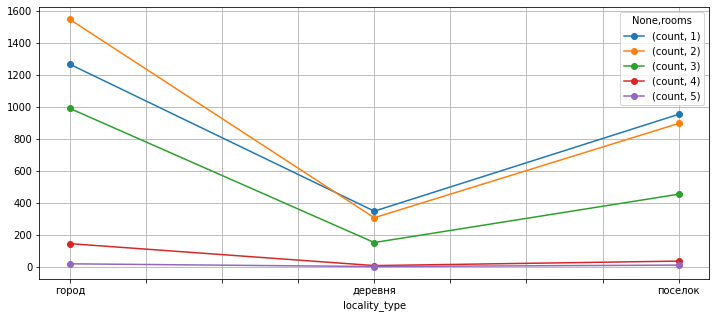

In [720]:
(
    data.query('locality_name != "Санкт-Петербург"')
    .pivot_table(index='locality_type', columns='rooms', values='1m', aggfunc=['count'])
    .plot(grid=True, style='o-', figsize=(12, 5))   
) 

Если исключить СПб (на долю которого приходится большая часть объявлений) средняя цена м2 в однокомнатной квартиры в поселке и деревни несколько выше, чем в городе (а медианная цена заметнее выше). (Вероятно поскольку в категорию "поселок" попали поселки городского типа). При этом количество объявлений о продажах однокмнатных, двухкомнатных и трехкомнатных квартир в городах (исключая СПб) почти в два раза больше, чем в поселках. Нормировать бы еще количество объявлений на душу населения и увидели бы паттерны деурбанизации малых городов ленинградской области.

In [721]:
# день публикации (0-пн, 1-вт, ...) 
data['weekday'] = data['first_day_exposition'].dt.weekday

In [722]:
# влияет ли день публикации на то, как долго висит объявления
data_pivot3 = data.pivot_table(index='weekday', values='days_exposition', aggfunc=['mean','count'])  
print(data_pivot3) 

                   mean           count
        days_exposition days_exposition
weekday                                
0            183.564426            2693
1            184.433933            3224
2            188.479602            3015
3            186.170162            3338
4            173.277231            3149
5            169.667794            1478
6            167.471139            1282


In [723]:
data_pivot4 = data.pivot_table(index='weekday', values='days_exposition', aggfunc=['median'])  
print(data_pivot4) 

                 median
        days_exposition
weekday                
0                  98.0
1                  95.0
2                  99.0
3                  98.0
4                  96.0
5                  96.0
6                  89.0


В среднем объявления опубликованные в выходные дни  висят на сайте чуть меньше, возможно, дело в том, что в выходные объявления о продаже квартире публикуют почти в два раза реже, чем в будни. По медиане выделяется только воскресенье.

In [724]:
# год публикации
data['year'] = data['first_day_exposition'].dt.year

In [725]:
# месяц публикации
data['month'] = data['first_day_exposition'].dt.month

In [726]:
# перекатегоризируем этажи: первый, последний, другой. (Na нет - Try-Exept не нужно)
def categorize_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_category'] = data.apply(categorize_floor, axis=1)

In [727]:
# влияет ли категория этажа на то, как долго висит объявление

data_pivot4 = data.pivot_table(index='floor_category', values='days_exposition', aggfunc=['mean','count'])  
print(data_pivot4)

                          mean           count
               days_exposition days_exposition
floor_category                                
другой              175.127307           13275
первый              204.845532            2350
последний           189.338684            2554


Медиана в отличие от среднего показывает, что есть выбросы в количестве дней, которое висят объявления о продаже квартир на крайних этажах. Интересно что не так с этими квартирами помимо этажности? (Однушки на первом? пятикомнатные пентхаусы с потолками 5 метров - на последнем?)   

In [728]:
data_pivot5 = data.pivot_table(index='floor_category', values='days_exposition', aggfunc=['median'])  
print(data_pivot5)

                        median
               days_exposition
floor_category                
другой                    91.0
первый                   117.0
последний                101.5


In [729]:
sample10 = data.query('floor_category in ["первый","последний"]')
sample10 = sample10[['1m','total_area','rooms','ceiling_height','floor_category','days_exposition']]
sample10.sort_values(by='days_exposition', ascending = False).head(30)

,1m,total_area,rooms,ceiling_height,floor_category,days_exposition
6691,102373.196836,42.98,1,2.65,первый,1512.0
14093,95000.000000,100.00,4,3.00,последний,1497.0
521,111765.754020,230.10,3,2.65,первый,1441.0
20996,62271.062271,54.60,2,2.50,первый,1413.0
6726,143104.271057,83.82,2,2.73,первый,1406.0
18262,20140.105079,57.10,2,2.65,последний,1396.0
12047,74525.745257,36.90,1,3.00,последний,1375.0
11421,101538.461538,32.50,1,2.55,первый,1362.0
17930,86438.709677,77.50,2,2.75,последний,1361.0
21755,137500.000000,60.00,3,3.00,первый,1349.0


Встречаются и однушки на первом и пентхаусы на последнем, но не в подавляющем большинстве.

In [730]:
sample_f = sample10.query('floor_category == "первый"')
sample_f.pivot_table(index='rooms', values='1m', aggfunc=['median','count'])

,median,count
,1m,1m
rooms,,
1,90651.558074,761
2,78475.336323,1115
3,77777.777778,705
4,77666.666667,151
5,84745.762712,43


Распределение комнат в объявлениях о продаже квартир на первом этаже нормальное, вероятно долго висят те объявления, в которых за м2 с соответствующим количеством комнат ставят слишком высокую цену.

In [731]:
sample_l = sample10.query('floor_category == "последний"')
sample_l.pivot_table(index='rooms', values='1m', aggfunc=['median','count'])

,median,count
,1m,1m
rooms,,
1,91194.968553,773
2,83333.333333,1176
3,84537.246050,827
4,94736.842105,179
5,85311.699402,45


Распределение комнат в объявлениях о продаже квартир на последнем этаже тоже нормальное, вероятно долго висят те объявления, в которых за м2 с соответствующим количеством комнат ставят слишком высокую цену. (В среднем м2 на последнем этаже подороже первого не зависимо от количества комнат).

In [732]:
def too_exp(row):
    if row['floor_category'] == "первый" and row['rooms'] == 1 and row['1m'] > 90651.558074:
        return True
    elif row['floor_category'] == "первый" and row['rooms'] == 2 and row['1m'] > 78475.336323:
        return True
    elif row['floor_category'] == "первый" and row['rooms'] == 3 and row['1m'] > 77777.777778:
        return True
    elif row['floor_category'] == "первый" and row['rooms'] == 4 and row['1m'] > 77666.666667:
        return True
    elif row['floor_category'] == "первый" and row['rooms'] == 5 and row['1m'] > 84745.762712:
        return True
    elif row['floor_category'] == "последний" and row['rooms'] == 1 and row['1m'] > 91194.968553:
        return True
    elif row['floor_category'] == "последний" and row['rooms'] == 2 and row['1m'] > 83333.333333:
        return True
    elif row['floor_category'] == "последний" and row['rooms'] == 3 and row['1m'] > 84537.246050:
        return True
    elif row['floor_category'] == "последний" and row['rooms'] == 4 and row['1m'] > 94736.842105:
        return True
    elif row['floor_category'] == "последний" and row['rooms'] == 4 and row['1m'] > 85311.699402:
        return True
    else:
        return False

sample10['too_expencive'] = sample10.apply(too_exp, axis=1)
        

In [733]:
sample10.sort_values(by='days_exposition', ascending = False).head(40)

,1m,total_area,rooms,ceiling_height,floor_category,days_exposition,too_expencive
6691,102373.196836,42.98,1,2.65,первый,1512.0,True
14093,95000.000000,100.00,4,3.00,последний,1497.0,True
521,111765.754020,230.10,3,2.65,первый,1441.0,True
20996,62271.062271,54.60,2,2.50,первый,1413.0,False
6726,143104.271057,83.82,2,2.73,первый,1406.0,True
18262,20140.105079,57.10,2,2.65,последний,1396.0,False
12047,74525.745257,36.90,1,3.00,последний,1375.0,False
11421,101538.461538,32.50,1,2.55,первый,1362.0,True
17930,86438.709677,77.50,2,2.75,последний,1361.0,True
21755,137500.000000,60.00,3,3.00,первый,1349.0,True


Завшенная цена на м2 в для соответствующего количества комнат в объявлениях о продаже квартиры на первом и последнем этажах не всегда объясняет, почему объявления долго висят. (Но это сильная детерминанта). 

In [734]:
# расстояние до центра в км.
data['center_km'] = (data['cityCenters_nearest'] / 1000).round()


In [735]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20976 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20976 non-null  int64         
 1   last_price            20976 non-null  int64         
 2   total_area            20976 non-null  float64       
 3   first_day_exposition  20976 non-null  datetime64[ns]
 4   rooms                 20976 non-null  int64         
 5   ceiling_height        20976 non-null  float64       
 6   floors_total          20976 non-null  int64         
 7   living_area           20976 non-null  float64       
 8   floor                 20976 non-null  int64         
 9   is_apartment          20976 non-null  bool          
 10  studio                20976 non-null  bool          
 11  open_plan             20976 non-null  bool          
 12  kitchen_area          20976 non-null  float64       
 13  balcony         

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Все необходимые колонки добавлены. Идём дальше)
</div>

### Проведите исследовательский анализ данных

In [736]:
data['total_area'].describe()

count    20976.000000
mean        58.527323
std         25.897821
min         12.000000
25%         41.000000
50%         53.000000
75%         69.400000
max        290.000000
Name: total_area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

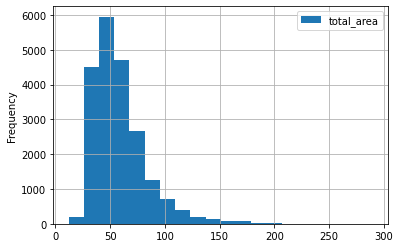

In [737]:
data.plot(kind='hist', y='total_area', bins=20, grid=True, legend=True)

In [738]:
sample = data.query('150 < total_area < 300')
print('количество объектов недвижимости с общей площадью более 150 м:', sample.shape[0])

количество объектов недвижимости с общей площадью более 150 м: 234


В датасете:
<br>
ок. 4500 квартир площадью от 25 до 35 м.
<br>
ок. 6000 квартир площадью от 35 до 55 м.
<br>
ок.  4500 квартир площадью от 55 до 65 м.
<br>
ок.  2700 квартир площадью от 65 до 75 м.
<br>
ок.  1200 квартир площадью от 75 до 85 м.
<br>
ок.  700 квартир площадью от 85 до 100 м.
<br>
ок.  1000 квартир площадью от 100 до 150 м.
<br>
234 квартир площадью от 150 до 295 м.


In [739]:
data['living_area'].describe()

count    20976.000000
mean        33.604439
std         16.542579
min         10.000000
25%         19.000000
50%         30.400000
75%         42.600000
max        180.000000
Name: living_area, dtype: float64

<AxesSubplot:xlabel='total_area', ylabel='living_area'>

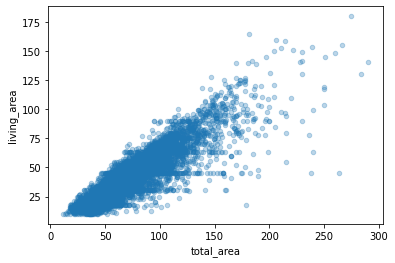

In [740]:
data.plot(kind='scatter', x='total_area', y='living_area', alpha=0.3)

<AxesSubplot:ylabel='Frequency'>

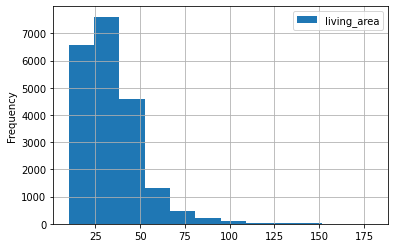

In [741]:
data.plot(kind='hist', y='living_area', bins=12, grid=True, legend=True)

In [742]:
sample14 = data.query('100 < living_area')
print('количество объектов недвижимости с жилой площадью более 100 м:', sample14.shape[0])

количество объектов недвижимости с жилой площадью более 100 м: 114


В датасете:
<br>
ок. 6500 квартир c жилой площадью от 10 до 25 м.
<br>
ок. 8000 квартир c жилой площадью от 25 до 35 м.
<br>
ок.  4500 квартир c жилой площадью от 35 до 50 м.
<br>
ок.  1200 квартир c жилой площадью от 50 до 70 м.
<br>
ок. 400 квартир c жилой площадью от 75 до 100 м.
<br>
114 квартир c жилой площадью более 100 м.

In [743]:
data['kitchen_area'].describe()

count    20976.000000
mean        10.123621
std          5.324122
min          0.000000
25%          7.000000
50%          9.000000
75%         11.600000
max         65.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:ylabel='Frequency'>

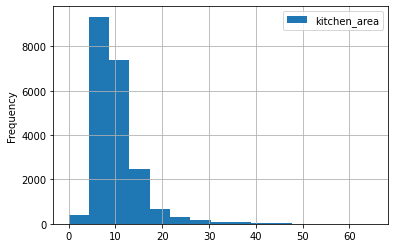

In [744]:
data.plot(kind='hist', y='kitchen_area', bins=15, grid=True, legend=True)

In [745]:
sample15 = data.query('40 < kitchen_area < 65')
print('количество объектов недвижимости с площадью кухни:', sample15.shape[0])

количество объектов недвижимости с площадью кухни: 82


В датасете:
<br>
ок. 100 квартир без кухни (площадь кухни - 0)
<br>
ок. 500 квартир c площадь кухни до 5 м. 
<br>
ок. 10000 квартир c площадь кухни от 5 до 10 м.
<br>
ок. 5000 квартир c площадь кухни от  10 до 15 м.
<br>
ок. 1000 квартир c площадь кухни от 15 до 20 м.
<br>
ок. 700 квартир c площадь кухни от 20 до 40
<br>
82 квартир c площадь кухни от 40 до 65 м.
<br>


In [746]:
data['last_price'].describe()

count    2.097600e+04
mean     5.748846e+06
std      3.981243e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.700000e+06
max      3.000000e+07
Name: last_price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

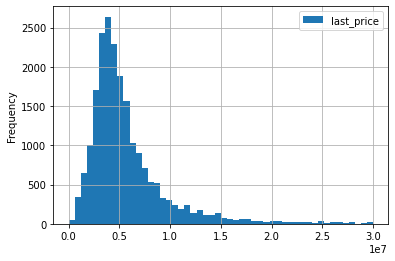

In [747]:
data.plot(kind='hist', y='last_price', bins=50, grid=True, legend=True, range=(1.219000e+04, 0.300000e+08))

In [748]:
data['last_price'].median()

4650000.0

Медианная цена квартиры в Лен. области - чуть больше 4.5 млн., а средняя - почти, 6 млн. из-за длинного хвости очень дорогих квартир (от 10 до 30 млн.). Среднестатистическая квартира - однушка или двушка площадью до 65 м2 и кухней от 5 до 10 м2

<AxesSubplot:ylabel='Frequency'>

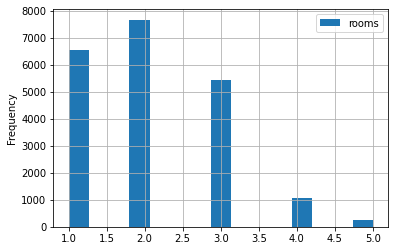

In [749]:
data.plot(kind='hist', y='rooms', bins=15, grid=True, legend=True)

In [750]:
data[data['rooms'] == 5].shape[0]

260

В датасете:
<br>
ок. 6500 однокомнатных квартир
<br>
ок. 7500 двухкомнатных квартир 
<br>
ок. 5500 трехкомнатных квартир
<br>
ок. 1000 четырехкомнатных квартир
<br>
260 квартир с 5-ю комнатами
<br>


In [751]:
data['ceiling_height'].describe()

count    20976.000000
mean         2.687948
std          0.209135
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:ylabel='Frequency'>

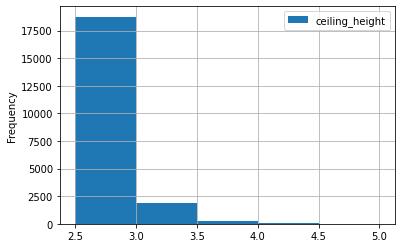

In [752]:
data.plot(kind='hist', y='ceiling_height', bins=5, grid=True, legend=True)

In [753]:
sample20 = data.query('3.5 < ceiling_height < 5')
print('количество объектов с потолками:', sample20.shape[0])

количество объектов с потолками: 208


В датасете:
<br>
ок. 18000 квартир с потолками от 2.5 до 3 м.
<br>
ок. 2000 квартир с потолками от 3 до 3.5 м. 
<br>
208 квартир с потолками от 3.5 до 5 м.


In [754]:
data['floor'].describe()

count    20976.000000
mean         5.653318
std          4.726861
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:ylabel='Frequency'>

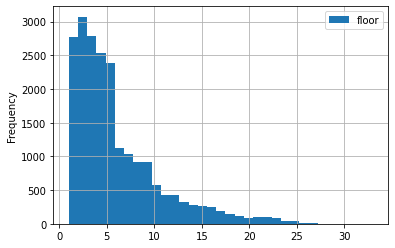

In [755]:
data.plot(kind='hist', y='floor', bins=33, grid=True, legend=True)

In [756]:
sample21 = data.query('10 < floor < 33')
print('количество объявлений с этажами:', sample21.shape[0])

количество объявлений с этажами: 2865


Заметно чаще прочих встречаются объявления о продаже квартиры на первых 5-и этажах:
<br>
на первом этаже - ок. 2700 объявлений
<br>
на втором этаже - ок. 3100 объявлений
<br>
на третьем этаже - ок. 2700 объявлений
<br>
на четвертом - ок. 2500 объявлений
<br>
на пятом - ок. 2400 объявлений
<br>
<br>
с 5 по 10 этажи - всего ок. 4000 объявлений
<br>
с 10 по 33 этажи - всего ок. 3000 объявлений


<AxesSubplot:>

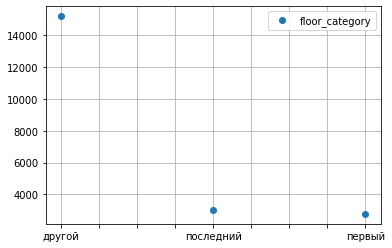

In [757]:
data['floor_category'].value_counts().plot(grid=True, legend=True, style='o')


Объявлений по категориям этажей:
<br>
другой - 13275
<br>
первый - 2350
<br>
последний - 2554

In [758]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20976 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20976 non-null  int64         
 1   last_price            20976 non-null  int64         
 2   total_area            20976 non-null  float64       
 3   first_day_exposition  20976 non-null  datetime64[ns]
 4   rooms                 20976 non-null  int64         
 5   ceiling_height        20976 non-null  float64       
 6   floors_total          20976 non-null  int64         
 7   living_area           20976 non-null  float64       
 8   floor                 20976 non-null  int64         
 9   is_apartment          20976 non-null  bool          
 10  studio                20976 non-null  bool          
 11  open_plan             20976 non-null  bool          
 12  kitchen_area          20976 non-null  float64       
 13  balcony         

In [759]:
data['floors_total'].describe()

count    20976.000000
mean        10.351163
std          6.461590
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         35.000000
Name: floors_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

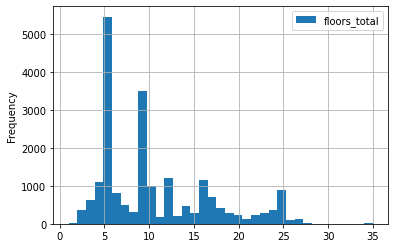

In [760]:
data.plot(kind='hist', y='floors_total', bins=35, grid=True, legend=True)

В датасете больше всего 5-и и 9-и этажных типовых домов:
<br>
2-х и 3-х этажных в сумме ок. 1000
<br>
4-х этажных ок. 1000
<br>
5-и этажных ок. 6000 
<br>
9-и этажных ок. 3500  
<br>
10-и этажных ок. 1000
<br>
12-и этажных ок. 1200
<br>
16-и этажных ок. 1200
<br>
25-и этажных ок 900
 


In [761]:
data['cityCenters_nearest'].describe()

count    16064.000000
mean     14320.448954
std       8720.239169
min        208.000000
25%       9388.000000
50%      13135.500000
75%      16360.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

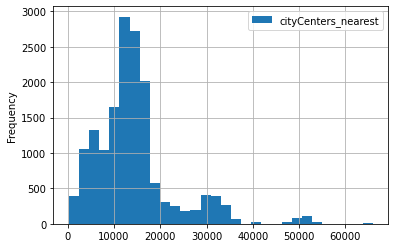

In [762]:
data.plot(kind='hist', y='cityCenters_nearest', bins=30, grid=True, legend=True)

In [763]:
sample22 = data.query('40000 < cityCenters_nearest < 60000')
print('количество объявлений по удаленноти от центра:', sample22.shape[0])

количество объявлений по удаленноти от центра: 275


Выделяются 4 группы квартир в зависимости от расстояния до центра:
<br>
- в сумме ок. 4500 квартир, расположенных от центра на расстоянии менее, чем в 10 км. (условно, исторический центр СПб, т.к. большинство объявления - СПб.)
<br>
- в сумме ок. 9200 квартир, расположенных от центра на расстоянии от 10 до 20 км. (условно, в пределах КАД исключая исторический центр,  т.к. большинство объявления - СПб.)
<br>
- в сумме ок. 1300 квартир, расположенных от центра на расстоянии от 25 до 35 км. 
<br>
- в сумме ок. 200 квартир, расположенных от центра на расстоянии от 40 до 60 км.

In [764]:
data['airports_nearest'].describe()

count    16046.000000
mean     28748.739063
std      12673.716553
min       6450.000000
25%      18490.000000
50%      26646.000000
75%      37288.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

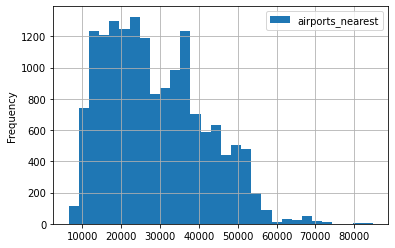

In [765]:
data.plot(kind='hist', y='airports_nearest', bins=30, grid=True, legend=True)

У гистограммы две вершины:
<br>
- более половины всех квартир расположены от 10 до 30 км от аэтопорта (по всей очевидности Пулково)
<br>
- одна четверть на расстоянии от 30 до 40 км. до аэропорта (по-видимому это квартиры севернее КАД, т.к. Пулково на юге, и в городах вокруг СПб)
<br>
<br>
последняя четверть расположены на расстоянии более 40 км.

In [766]:
data['parks_nearest'].describe()

count    7129.000000
mean      491.057091
std       339.500092
min         1.000000
25%       288.000000
50%       456.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

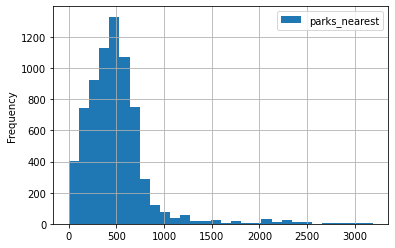

In [767]:
data.plot(kind='hist', y='parks_nearest', bins=30, grid=True, legend=True)

Парки важны (влияют на стоимость 1 м2) в радиусе 1 км, далее их либо пересают указывать, либо это квартиры в населнных пунктах без парков.
<br>
ок. 400 квартир на расстоянии 100 м. от парка
<br>
ок. 700 квартир на расстоянии 200 м. от парка
<br>
ок. 900 квартир на расстоянии 300 м. от парка
<br>
ок. 1100 квартир на расстоянии 400 м. от парка
<br>
ок. 1300 квартир на расстоянии 500 м. от парка
<br>
ок. 1000 квартир на расстоянии 600 м. от парка
<br>
ок. 700 квартир на расстоянии 700 м. от парка
<br>
ок. 300 квартир на расстоянии 800 м. от парка
<br>
<br>
Всего четверть квартир в датафрейме в радиусе 1 км. - остальные либо дальше, либо парка нет.

<AxesSubplot:ylabel='Frequency'>

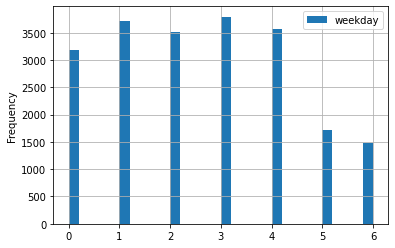

In [768]:
data.plot(kind='hist', y='weekday', bins=30, grid=True, legend=True)

В выходные объявления о продаже квартире публикуют почти в два раза реже, чем в будни.

<AxesSubplot:ylabel='Frequency'>

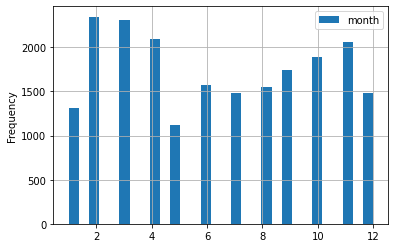

In [769]:
data.plot(kind='hist', y='month', bins=30, grid=True, legend=True)

Зимой (исключая Феврать) и летом публикуют меньше объявлений, чем осенью и весной (исключая Май). В целом волны - колебания вокруг среднего (1725) с некоторым стандартным отклонением (все месяцы укладываются в одно). Меньше всего объявлений в январе и мае. Больше всего в феврале и марте.

#### Сколько дней виcят объявления

In [770]:
data['days_exposition'].describe()

count    18179.000000
mean       180.965565
std        219.196489
min          1.000000
25%         45.000000
50%         96.000000
75%        231.500000
max       1553.000000
Name: days_exposition, dtype: float64

In [771]:
data['days_exposition'].median()

96.0

<AxesSubplot:ylabel='Frequency'>

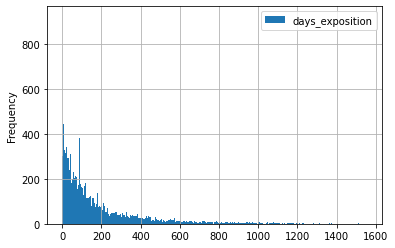

In [772]:
data.plot(kind='hist', y='days_exposition', bins=500, grid=True, legend=True)

Быстрыми можно можно счить продажи до 96 дней.
<br>
Необычно долгимим - дольше 231 дня (75%).
<br>
Аномально долгими - среднее (180) + 2 стандартных отклонения (440) - дольше 620 дней (более полтутора лет). 

#### Что сильнее влияет на общую стоимость

In [773]:
data_inf = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday','year', 'month']]

In [774]:
data_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20976 entries, 0 to 23698
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   last_price    20976 non-null  int64  
 1   total_area    20976 non-null  float64
 2   living_area   20976 non-null  float64
 3   kitchen_area  20976 non-null  float64
 4   rooms         20976 non-null  int64  
 5   weekday       20976 non-null  int64  
 6   year          20976 non-null  int64  
 7   month         20976 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.4 MB


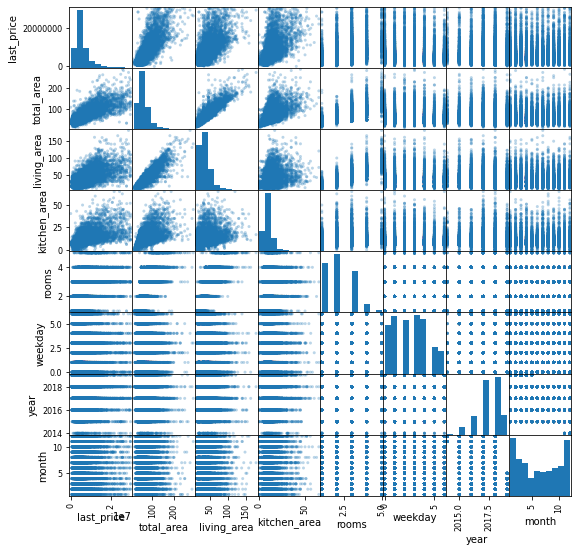

In [775]:
pd.plotting.scatter_matrix(data_inf, figsize=(9, 9), alpha=0.3);

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

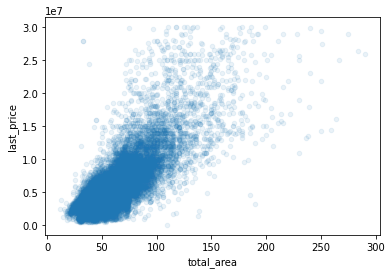

In [776]:
data_inf.plot(kind='scatter', x='total_area', y='last_price', alpha=0.09)


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

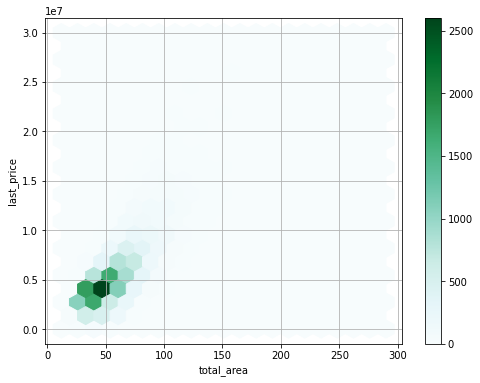

In [777]:
data_inf.plot(kind='hexbin', x='total_area', y='last_price', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

<AxesSubplot:xlabel='year', ylabel='last_price'>

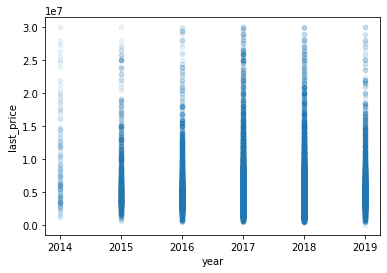

In [778]:
data_inf.plot(kind='scatter', x='year', y='last_price', alpha=0.09)

<AxesSubplot:xlabel='year', ylabel='last_price'>

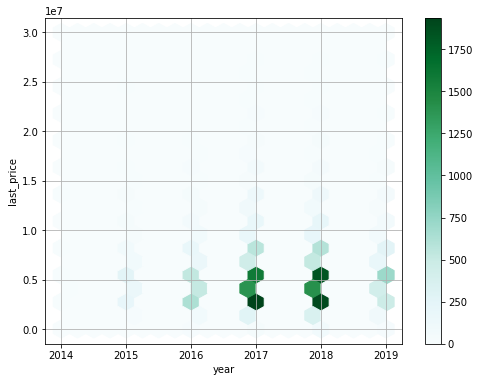

In [779]:
data_inf.plot(kind='hexbin', x='year', y='last_price', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

<AxesSubplot:ylabel='Frequency'>

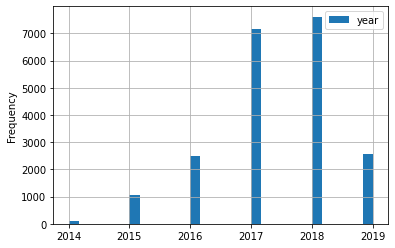

In [780]:
data.plot(kind='hist', y='year', bins=30, grid=True, legend=True)

За 2017 и 2018 объявлений в два раза больше, чем за другие годы.

<AxesSubplot:xlabel='year', ylabel='kitchen_area'>

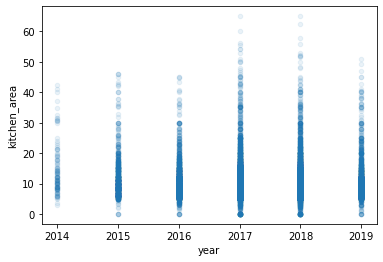

In [781]:
data_inf.plot(kind='scatter', x='year', y='kitchen_area', alpha=0.09)

In [782]:
data.pivot_table(index='year', values='kitchen_area', aggfunc=['median'])

,median
,kitchen_area
year,
2014,12.0
2015,10.0
2016,9.0
2017,9.0
2018,9.0
2019,8.5


In [783]:
data_kitch = data.query('kitchen_area >= 30')

In [784]:
data_kitch.pivot_table(index='year', values='kitchen_area', aggfunc=['median','count'])

,median,count
,kitchen_area,kitchen_area
year,,
2014,31.7,13
2015,37.7,25
2016,35.0,29
2017,36.0,100
2018,35.4,91
2019,36.0,42


<AxesSubplot:xlabel='year'>

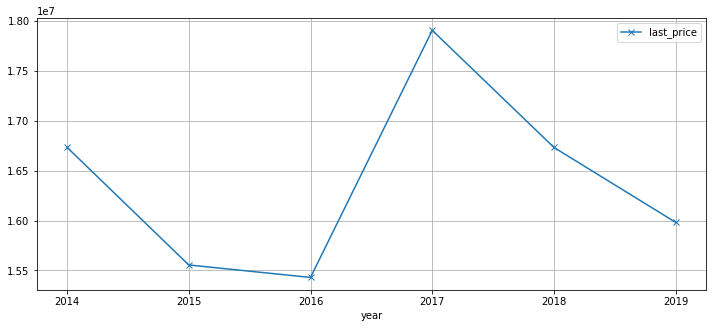

In [785]:
(
    data_kitch.pivot_table(index=['year'], values='last_price', aggfunc='mean')
    .plot(grid=True, figsize=(12, 5), style='x-')
) 

Для выборки с большими кухнями (30 м. м более) средняя общая цена за 2018 г. (за который объявлений с такими кухнями 91) не отличается от средней цены за 2014 г. (за который объявлений с такими кухнями всего 13). За 2017 средняя общая цена - максимальное значение.

<AxesSubplot:xlabel='year'>

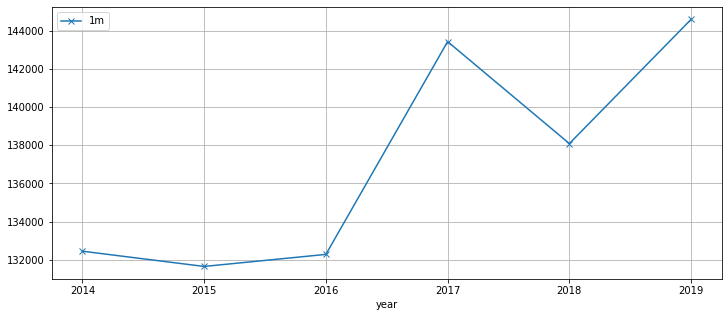

In [786]:
(
    data_kitch.pivot_table(index=['year'], values='1m', aggfunc='mean')
    .plot(grid=True, figsize=(12, 5), style='x-')
) 

In [787]:
data.pivot_table(index='year', values='last_price', aggfunc=['median'])

,median
,last_price
year,
2014,7540000
2015,5270000
2016,4550000
2017,4500000
2018,4600000
2019,5100000


Сильнее всего на общую цену влияет общая площадь. Количество комнат положительно связано с общей площадью. День, месяц и год практически никак не влияют на общую цену. 
<br>
За 2017 и 2018 объявлений в два раза больше, чем за другие годы. Медианная площадь кухни по годам уменьшилась (неравномерно). В 2017 и 2018 очень большая кухня (30 м. м более) встречается в три раза чаще, чем в предшествующие годы и в два раза чаще, чем в 2019 г. Год все же не влияет на общую цену.

In [788]:
data_pivot4 = data.pivot_table(index='floor_category', values='days_exposition', aggfunc=['mean','count'])  
print(data_pivot4)

                          mean           count
               days_exposition days_exposition
floor_category                                
другой              175.127307           13275
первый              204.845532            2350
последний           189.338684            2554


<AxesSubplot:xlabel='year'>

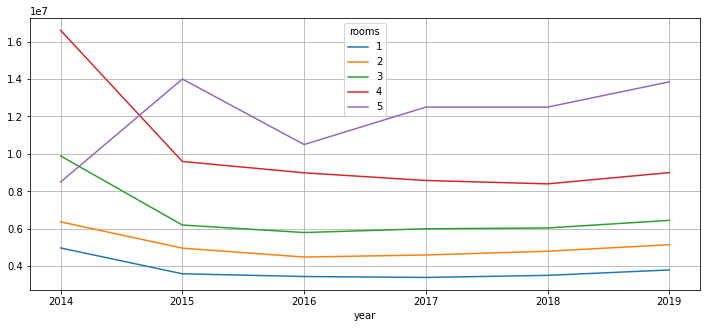

In [789]:
(
    data.pivot_table(index=['year'], columns='rooms', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
) 

Начиная с 2014 медианные цены на квартиры снижались. После 2017 наметилось медленное восстановление цен на одно-, двух-, трехкомнатные квартиры. Цены одно-, двух-, трех- и четырехкомнатных квартир так и не вернулись на уровень 2014 г. Цена на пятикомнатные квартиры показывали отличающийся тренд (в 2019 они на максимуме 2015 года).

<AxesSubplot:xlabel='floor_category'>

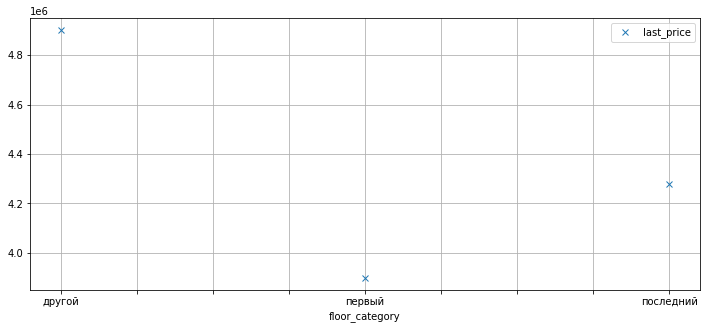

In [790]:
(
    data.pivot_table(index=['floor_category'], values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5), style='x')
) 

Категория этажа влияет на общую цену квартиры. На первом этаже квартиры дешевле, чем на других. На последнем - дешевле, чем на других. Как показывает график ниже, эта тенденция в целом устойчива во времени. 

<AxesSubplot:xlabel='year'>

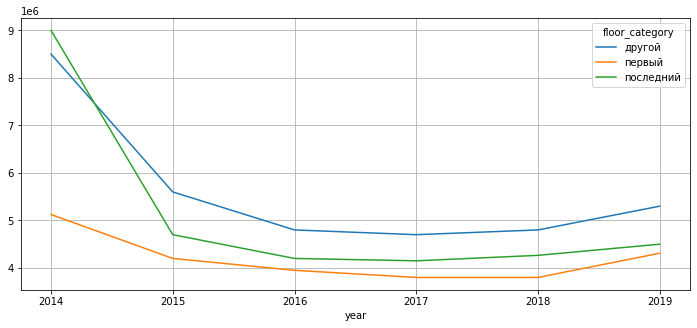

In [791]:
(
    data.pivot_table(index=['year'], columns='floor_category', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
) 

Тенденция первый самый дешевый, затем последний, затем другие - устойчива во времени.

<AxesSubplot:xlabel='rooms'>

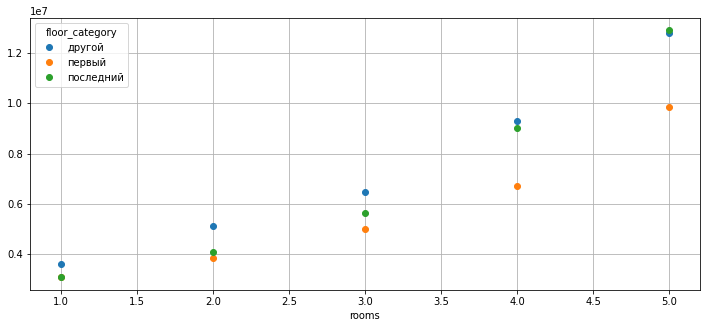

In [792]:
(
    data.pivot_table(index=['rooms'], columns='floor_category', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5), style='o')
) 

Медианные ценны на 4-х и 5-и комнатные квартиры на первом этаже на миллион ниже, чем на последнем или другом (на них ценны на 4-х и 5-и комнатные квартиры практически не отличаются). Медианные цены 1 и 2 комнатных квартир на первом и последнем этажах мало отличаются. 

In [793]:
print('корреляция м-ду общей площадью и количеством комнат:', data['total_area'].corr(data['rooms']))

корреляция м-ду общей площадью и количеством комнат: 0.7712965216451995


In [794]:
print('корреляция м-ду жилой площадью и количеством комнат:', data['living_area'].corr(data['rooms']))

корреляция м-ду жилой площадью и количеством комнат: 0.8720106780362149


In [795]:
print('корреляция м-ду площадью кухни и количеством комнат:', data['kitchen_area'].corr(data['rooms']))

корреляция м-ду площадью кухни и количеством комнат: 0.2259304902596449


In [796]:
print('корреляция м-ду общей ценой и общей площадью :', data['last_price'].corr(data['total_area']))

корреляция м-ду общей ценой и общей площадью : 0.7838599881278463


In [797]:
print('корреляция м-ду общей ценой и жилой площадью :', data['last_price'].corr(data['living_area']))

корреляция м-ду общей ценой и жилой площадью : 0.6508439922766468


In [798]:
print('корреляция м-ду общей ценой и площадью кухни:', data['last_price'].corr(data['kitchen_area']))

корреляция м-ду общей ценой и площадью кухни: 0.6285823518688298


In [799]:
print('корреляция м-ду общей ценой и количеством комнат:', data['last_price'].corr(data['rooms']))

корреляция м-ду общей ценой и количеством комнат: 0.48294694978085384


In [800]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20976 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20976 non-null  int64         
 1   last_price            20976 non-null  int64         
 2   total_area            20976 non-null  float64       
 3   first_day_exposition  20976 non-null  datetime64[ns]
 4   rooms                 20976 non-null  int64         
 5   ceiling_height        20976 non-null  float64       
 6   floors_total          20976 non-null  int64         
 7   living_area           20976 non-null  float64       
 8   floor                 20976 non-null  int64         
 9   is_apartment          20976 non-null  bool          
 10  studio                20976 non-null  bool          
 11  open_plan             20976 non-null  bool          
 12  kitchen_area          20976 non-null  float64       
 13  balcony         

In [801]:
# По каким населенным пунктам больше всего объявлений о продаже квартир
print(data['locality_name'].value_counts().head(10))

Санкт-Петербург      13828
поселок Мурино         432
поселок Шушары         394
Всеволожск             353
Пушкин                 339
Колпино                310
поселок Парголово      273
Гатчина                270
деревня Кудрово        244
Выборг                 231
Name: locality_name, dtype: int64


Больше всего объявлений о продаже квартир в СПб - 13828.

In [802]:
data_top = data.query('locality_name in ["Санкт-Петербург", "поселок Мурино", "поселок Шушары", "Всеволожск", "Пушкин", "Колпино", "поселок Парголово", "Гатчина", "деревня Кудрово", "Выборг"]')

In [803]:
top = data_top.pivot_table(index='locality_name', values='1m')
top.sort_values(by='1m', ascending = False)

,1m
locality_name,
Санкт-Петербург,110040.974733
Пушкин,102627.175909
деревня Кудрово,92316.721913
поселок Парголово,89082.048470
поселок Мурино,84332.693780
поселок Шушары,77918.018797
Колпино,74953.212741
Всеволожск,68420.652096
Гатчина,68330.952815


Самая высокая средняя цена за 1м2 в населенных пунктах с наибольшим количеством объявлений в СПб и Пушкине.

In [804]:
data_SPb = data.query('locality_name == "Санкт-Петербург"')

In [805]:
data_SPb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 0 to 23697
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          13828 non-null  int64         
 1   last_price            13828 non-null  int64         
 2   total_area            13828 non-null  float64       
 3   first_day_exposition  13828 non-null  datetime64[ns]
 4   rooms                 13828 non-null  int64         
 5   ceiling_height        13828 non-null  float64       
 6   floors_total          13828 non-null  int64         
 7   living_area           13828 non-null  float64       
 8   floor                 13828 non-null  int64         
 9   is_apartment          13828 non-null  bool          
 10  studio                13828 non-null  bool          
 11  open_plan             13828 non-null  bool          
 12  kitchen_area          13828 non-null  float64       
 13  balcony         

<AxesSubplot:xlabel='center_km', ylabel='1m'>

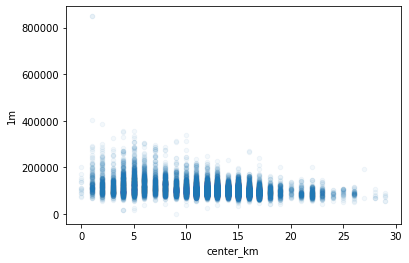

In [806]:
data_SPb.plot(kind='scatter', x='center_km', y='1m', alpha=0.05)

In [807]:
data_SPb_test = data_SPb[data_SPb['1m'] <= 400000]

<AxesSubplot:xlabel='center_km', ylabel='1m'>

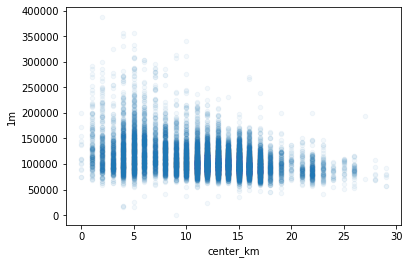

In [808]:
data_SPb_test.plot(kind='scatter', x='center_km', y='1m', alpha=0.05)

<AxesSubplot:xlabel='center_km'>

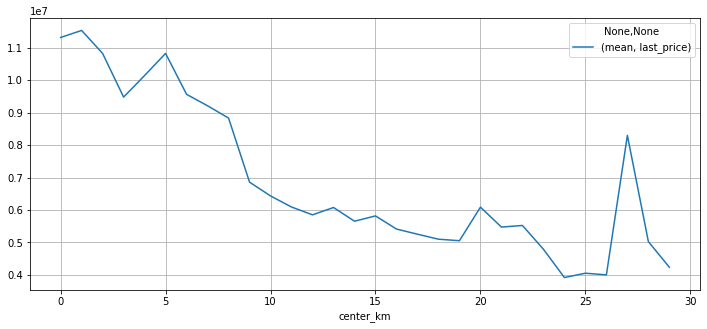

In [809]:
(
    data_SPb.pivot_table(index='center_km', values='last_price', aggfunc=['mean'])
    .plot(grid=True, figsize=(12, 5))
)

<AxesSubplot:xlabel='center_km'>

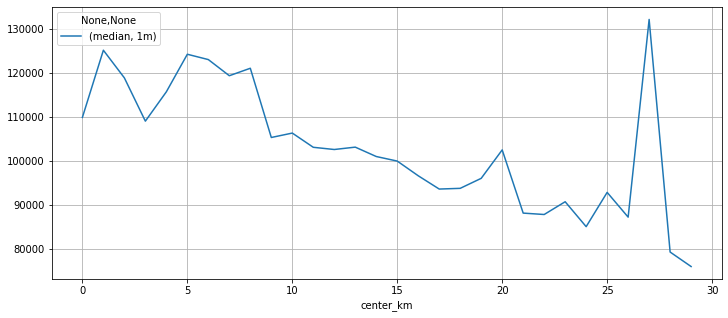

In [810]:
(
data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='center_km', values='1m', aggfunc=['median'])
    .plot(grid=True, figsize=(12, 5))
)

In [811]:
(
data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='center_km', values='1m', aggfunc=['median'])
)

,median
,1m
center_km,
0.0,109900.000000
1.0,125135.746606
2.0,118867.924528
3.0,109054.681885
4.0,115705.765408
5.0,124221.774194
6.0,123014.959724
7.0,119354.838710


В СПб чем ближе к центру, тем выше средняя и медианная цена 1м2. На расстоянии 5 км до центра есть выбросы (сильное влияние прочих факторов на цену), мешающие оценить влияние на стоимость 1 км. На расстоянии от 5 до 20 км до центра каждый км снижает стоимость каждого м2 на ок. 2000 р. После 20 км. снова начинается волатильность, т.е. сильное влияние прочих факторов помимо расстояния на цену.

### Общий вывод

Общая площадь большинства (99%) квартир в датасете не превышает 150 м.
<br>
Жилая площадь большинства (99%) квартир в датасете не превышает 100 м.
<br>
Медианная цена квартиры в Лен. области - чуть больше 4.5 млн., а средняя - почти, 6 млн.
<br>
Среднестатистическая квартира (ок. 50% объявлений) - однушка или двушка площадью до 65 м2 и кухней до 10 м2.
<br>
В 98% объявлений высота потолков не превышает 3,5 м. (зачастую от 2,5 до 3 м).
<br>
Заметно чаще прочих встречаются объявления о продаже квартиры на первых 5-и этажах.
<br>
Ок. половины всех объявлений о продаже квартиры в  5-и и 9-и этажных типовых домах.
<br>
Ок. половины всех объявлений в домах расположенных в пределах 20 км. от центра города.
<br>
Более половины всех объявлений в домах расположеных от 10 до 30 км от аэтопорта.
<br>
Парки важны (влияют на стоимость 1 м2) в радиусе 1 км, далее их либо пересают указывать, либо это квартиры в населнных пунктах без парков, либо парки дальше (в т.ч. далее 3 км.)
<br>
<br>
В выходные объявления о продаже квартире публикуют почти в два раза реже, чем в будни.
<br>
<br>
Быстрыми можно можно счить продажи до 96 дней.
<br>
Необычно долгимим - дольше 231 дня (75%).
<br>
Аномально долгими - дольше 620 дней (более полтутора лет). 
<br>
<br>
На общую цену квартиры влияют несколько факторов: общая площадь, жилая площадь, площадь кухни, количество комнат. Общая площадь, жилая площадь и количество комнат связаны между собой. Корреляция м-ду общей площадью и количеством комнат - 0.77, м-ду жилой площадью и количеством комнат - 0.87. Корреляция м-ду площадью кухни и количеством комнат - 0.23.
<br>
Сильнее всего на общую цену квартиры влияет общая площадь. Корреляция общую цену квартиры с общей площадью - 0.78.
<br>
Корреляция общей цены квартиры с жилой площадью - 0.65. Корреляция общей цены квартиры с  площадью кухни - 0.62. Корреляция м-ду общей ценой и количеством комнат - 0.48. 
<br>
День, месяц и год практически никак не влияют на общую цену. 
За 2017 и 2018 количество объявлений в два раза больше, чем за другие годы. Медианная площадь кухни по годам уменьшилась (неравномерно). В 2017 и 2018 очень большая кухня (30 м. м более) встречается в три раза чаще, чем в предшествующие годы и в два раза чаще, чем в 2019 г. 
<br>
Начиная с 2-х комнатных квартир средняя площадь кухни растет с количеством комнат, но порядок прироста площади не большой - всего несколько квадратных метром. 
<br>
<br>
Категория этажа влияет на общую цену квартиры. На первом этаже квартиры дешевле, чем на последнем и на других. На последнем - дешевле, чем на других. Эта тенденция в целом устойчива во времени (по годам).
<br>
<br>
Медианные ценны на 4-х и 5-и комнатные квартиры на первом этаже почти на миллион ниже, чем на последнем или другом. На последнем или другом цены на 4-х и 5-и комнатные квартиры практически не отличаются. Медианные цены 1 и 2 комнатных квартир на первом и последнем этажах мало отличаются.
<br>
<br>
Распределение комнат в объявлениях о продаже квартир на первом этаже нормальное: чаще всего продаются двухкомнатные квартиры, самая высокая медианная цена за 1м2 в однокомнатных квартирах.
<br>
<br>
Распределение комнат в объявлениях о продаже квартир на последнем этаже нормальное: чаще всего продаются двухкомнатные квартиры, самая высокая медианная цена за 1м2 в четырехкомнатных квартирах.
<br>
<br>
Завшенная цена на 1м2 в для соответствующего количества комнат в объявлениях о продаже квартиры на первом и последнем этажах зачастую, хотя и не всегда, объясняет, почему объявления об их продаже висят аномально долго. (Это сильная детерминанта).
<br>
<br>
Если исключить СПб, на долю которого приходится больше половины объявлений, средняя цена 1м2 в однокомнатной квартиры в поселке и деревне несколько выше, чем в городе (а медианная цена заметнее выше). (Вероятно поскольку к категории "поселок" были отнесены "поселки городского типа"). При этом количество объявлений о продажах однокмнатных, двухкомнатных и трехкомнатных квартир в городах (исключая СПб) почти в два раза больше, чем в поселках.
<br>
<br>
Больше всего объявлений в следующих населенных пунктах:
<br>
<br>
Санкт-Петербург      13828
<br>
поселок Мурино         432
<br>
поселок Шушары         394
<br>
Всеволожск             353
<br>
Пушкин                 339
<br>
Колпино                310
<br>
поселок Парголово      273
<br>
Гатчина                270
<br>
деревня Кудрово        244
<br>
Выборг                 231
<br>
<br>
Самая высокая средняя цена за 1м2 в следующих населенных пунктах с наибольшим количеством объявлений:
<br>
<br>
Санкт-Петербург 110040.974733
<br>
Пушкин	102627.175909
<br>
деревня Кудрово	92316.721913
<br>
поселок Парголово	89082.048470
<br>
поселок Мурино	84332.693780
<br>
поселок Шушары	77918.018797
<br>
Колпино	74953.212741
<br>
Всеволожск	68420.652096
<br>
Гатчина	68330.952815
<br>
Выборг	58281.272237
<br>
<br>
В СПб чем ближе к центру, тем выше средняя и медианная цена 1м2. На расстоянии 5 км до центра есть выбросы (сильное влияние прочих факторов на цену), мешающие оценить влияние на стоимость 1 км. На расстоянии от 5 до 20 км до центра каждый км снижает стоимость каждого м2 на ок. 2000 р. После 20 км. снова начинается волатильность, т.е. сильное влияние прочих факторов помимо расстояния на цену.
<br>
<br>
В целом по Лен.области, начиная с 2014 количество объявлений росло, а медианные цены на квартиры снижались. После 2017 наметилось медленное восстановление цен на одно-, двух-, трехкомнатные квартиры. (Максимальное количество объявлений более 7000 в 2017 и 2018 г., в 2019 объявлений ок. 2500 но это в несколько раз больше, чем в 2014 и 2015). Цены одно-, двух-, трех- и четырехкомнатных квартир так и не вернулись на уровень 2014 г. Цена на пятикомнатные квартиры показывала отличающийся тренд - в 2019 они на абсолютном максимуме 2015 года.
